<center>

# Group Testing with features
## A project for the class "Mathematics and Optimal Transport for Data Science"
### Linus Bleistein
    

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch
import sys
import cvxpy as cp
import tqdm
import importlib
import sklearn
import pandas as pd

In [2]:
import reconstruction_alg as rec
from utils import *

# Reconstruction algorithms

## Creating input vectors and test matrices

For this project, we implement 4 different "reconstruction algorithms". Given a test matrix $\mathbf{M}$ of size $T \times n$ and a test result $\mathbf{y}$ in $\left\{0,1 \right\}^T$, these algorithms seek to reconstruct the vector $ \mathbf{x} \in \left\{0,1\right\}^n$ that is linked to $\mathbf{y}$ and $\mathbf{M}$ through the relation 

$$ \mathbf{y} =  \mathbf{M} \mathbf{x}.$$

More precisions are given in the companion .pdf file to this project. 

Let us first introduce small utility functions. 
- The function `vsparse_input(n,k,p,iid=False)` creates an vector in $\left\{0,1\right\}^n$ in the very sparse regime (see companion pdf file for details). If `iid=False`, the vector is generated with a combinatorial prior, the number of defectives being equal to `k`. If `iid=True`, the vector is generated according to a iid prior, were entries are set to 1 with probability `p`. 
- The function `sparse_input(n,alpha)` creates an input vector in $\left\{0,1\right\}^n$ in the sparse regime. The number of defectives is equal to $int(n^\alpha)$.
- The function `linear_input(n,beta)` generates an input vector in $\left\{0,1\right\}^n$ of which $\beta \times n$ entries are set to 1.

In [3]:
x = vsparse_input(100,3,0,iid=False)
print(x)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [4]:
x = sparse_input(100,1/2)
print(x)

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 0. 0. 0.]


In [5]:
x = linear_input(100,0.8)
print(x)

[1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1.
 1. 1. 1. 1.]


The function `b_tests(T,n,p)` creates a test matrix $\mathbf{M}$ of size $T \times n$ (i.e. $T$ tests for a population of $n$ individuals)  with entries in $\left\{0,1 \right\}$ set randomly to 1 with probability $p$ - this corresponds to the so-called "Bernouilli test design".

In [4]:
m = b_tests(4,100,0.1)
print('This is the test matrix:\n',m)
print('This is the test result:\n',np.int32(m@x >= 1))

This is the test matrix:
 [[1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0
  1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0
  0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
  1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
  0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]]
This is the test result:
 [1 0 0 0]


Conversly, `ctpi_tests(T,n,L)` creates a test matrix $\mathbf{M}$ of size $T \times n$ such that every item is tested $L$ times, i.e. every column sums to $L$. This framework is called constant tests-per-item design.

In [8]:
print(ctpi_tests(10,10,3))

[[0 0 0 0 0 1 1 1 0 0]
 [1 1 0 0 1 1 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 1 1 0 0 1 0 0 0]
 [0 1 1 0 1 1 1 1 0 0]
 [0 1 0 0 0 0 0 0 1 0]
 [1 0 1 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 1 0 0 0 0 0 0]
 [1 0 0 1 0 0 0 1 0 1]]


## The COMP algorithm

The COMP algorithm is the most basic one can think of: given a test result and a test matrix, it declares as healthy all individuals that are in negative tests, and positive all others. It is conservative in the sens that it only makes false positives, and no false negatives.
You can instanciate the algorithm with a true vector $\mathbf{x}$ and a test matrix $\mathbf{M}$ by calling `COMP(true_x,test_matrix)`. Methods and a more detailled description of the algorithm can be found by calling `help()`.

In [5]:
comp = rec.COMP(x,m)

`reconstruct()` gives the approximation of the true vector $\mathbf{x}$ computed by the algorithm. 

In [6]:
print(comp.reconstruct())

[1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 1. 0.]


`accuracy()` computes the 0-1 loss.

In [7]:
print(comp.accuracy())

0.31


Finally, the method `confusion_matrix(plot=False,absv=False)` yields the confusion matrix of the algorithm. If `plot=True`, it plots it using `seaborn`. If `absv=True`, it gives absolute values instead of percentages.  

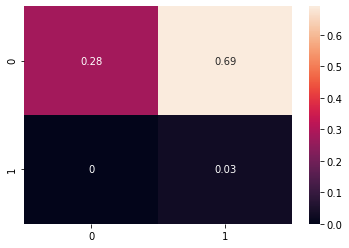

In [8]:
comp.confusion_matrix(plot=True)

## The DD algorithm

The DD algorithm works in three stages:
- It performs a COMP stage 
- It then declares positive all individuals that are in tests groups from which all other members have been declared healthy in the previous step. 
- Finally, it classifies as healthy all remaining individuals. 

This last step is motivated by the high sparsity of the vector $x$: since $x$ is sparse, there is little chance to create false negatives. Notice also that this algorithm only makes false negatives.  
Methods and instanciation are identical to the COMP algorithm.

0.08
0


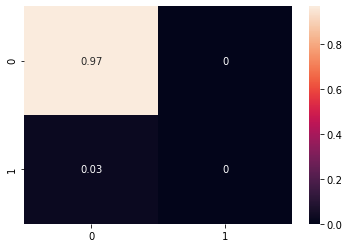

In [9]:
dd = rec.DD(x,m)
print(comp.f1score())
print(dd.precision())
dd.confusion_matrix(plot=True)

## The SCOMP algorithm

The SCOMP algorithm works in a recursive manner:
- It first performs the two first steps of the DD algorithm, but without declaring all non identified individuals as healthy. This produces an estimated vector $\mathbf{\tilde{x}}$.
- It then iteratively checks if $ \mathbf{y}=\mathbf{M}\mathbf{\tilde{x}}$. If not, it identifies the individual which is present in the greatest number of unexplained tests (i.e. positive tests which do not include any individual that is already known to be positive) and declares her positive. 

Methods and instanciation are identical.

0.96


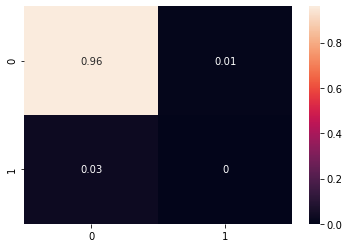

In [10]:
scomp = rec.SCOMP(x,m)
print(scomp.accuracy())
scomp.confusion_matrix(plot=True)

## The LP relaxation algorithm

The LP relaxation algorithm computes an estimation by solving an convex optimization problem, which is a relaxed version of the non-convex combinatorial problem of group testing. The solver used here is CVXPY. Methods and instanciation are identical.

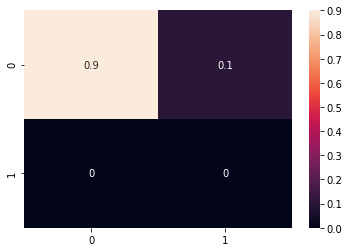

In [13]:
lp = rec.LP(x,m)
lp.score()
lp.confusion_matrix(plot=True)

## Some first comparaisons

We run some first basic tests to compare the different reconstruction algorithms in different contexts. Our tests work as follows: we generate an input vector and a test matrix, and try to reconstruct the vector x through different algorithms by using only the $k$ first rows of the test matrix, for $k$ ranging from 1 to the total number of rows of the test matrix. This is eventullay repeated $n$ times, and we then average.

### Sparse vs. dense setting

In [70]:
#Hyperparameters 

n_tests = 100
k = 2
matrix_p = 1/k
x_size = 100
max_test_size = 100

In [71]:
importlib.reload(rec)

comp_f1scores = np.zeros(max_test_size)
comp_succes = np.zeros(max_test_size)
dd_f1scores = np.zeros(max_test_size)
dd_succes = np.zeros(max_test_size)
scomp_f1scores = np.zeros(max_test_size)
scomp_succes = np.zeros(max_test_size)
lp_f1scores= np.zeros(max_test_size)
lp_succes = np.zeros(max_test_size)


for grouptest in tqdm.tqdm(np.arange(n_tests)):
    
    matrix = b_tests(max_test_size,x_size,matrix_p)
    true_x = vsparse_input(x_size,k,0)
    
    for size in np.arange(0,max_test_size):
        
        test_matrix = matrix[0:size+1,:]
        
        comp = rec.COMP(true_x,test_matrix) 
        comp_f1scores[size] += comp.f1score()
        succes = (comp.reconstruct() == true_x).all()
        comp_succes[size] += succes*1
        
        dd = rec.DD(true_x,test_matrix)
        dd_f1scores[size] += dd.f1score()
        succes = (dd.reconstruct() == true_x).all()
        dd_succes[size] += succes*1
        
        scomp = rec.SCOMP(true_x,test_matrix)
        scomp_f1scores[size] += scomp.f1score()
        succes = (scomp.reconstruct() == true_x).all()
        scomp_succes[size] += succes*1
        
        
        lp = rec.LP(true_x,test_matrix)
        lp_f1scores[size] += lp.f1score()
        succes = (lp.reconstruct() == true_x).all()
        lp_succes[size] += succes*1

comp_f1scores *= 1/n_tests
comp_succes *= 1/n_tests
scomp_f1scores *= 1/n_tests
scomp_succes *= 1/n_tests
dd_f1scores *= 1/n_tests
dd_succes *= 1/n_tests
lp_f1scores *= 1/n_tests
lp_succes *= 1/n_tests
        
        
        
        

100%|██████████| 100/100 [08:28<00:00,  5.08s/it]


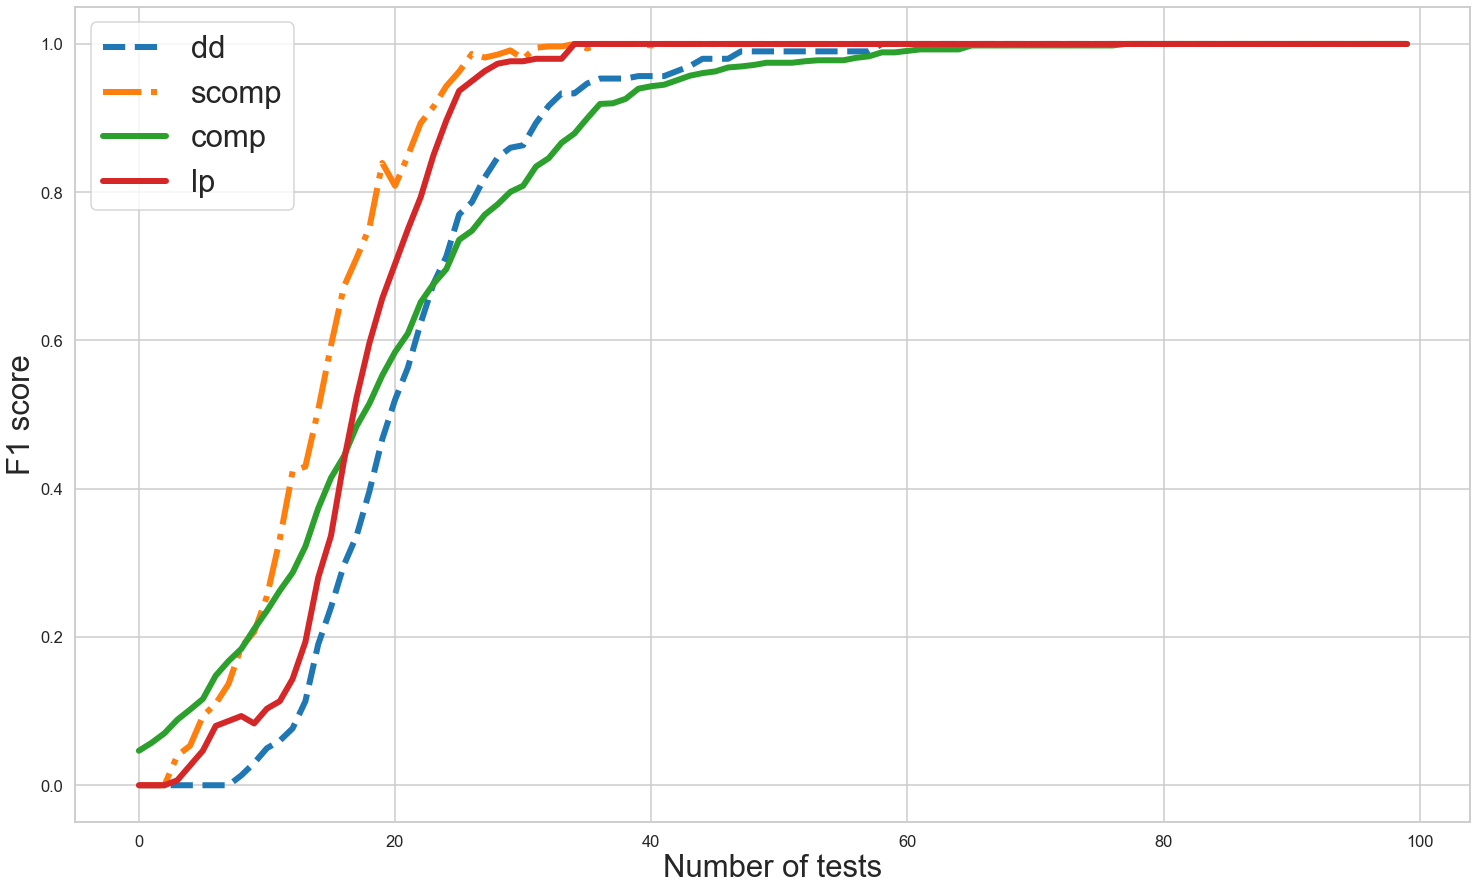

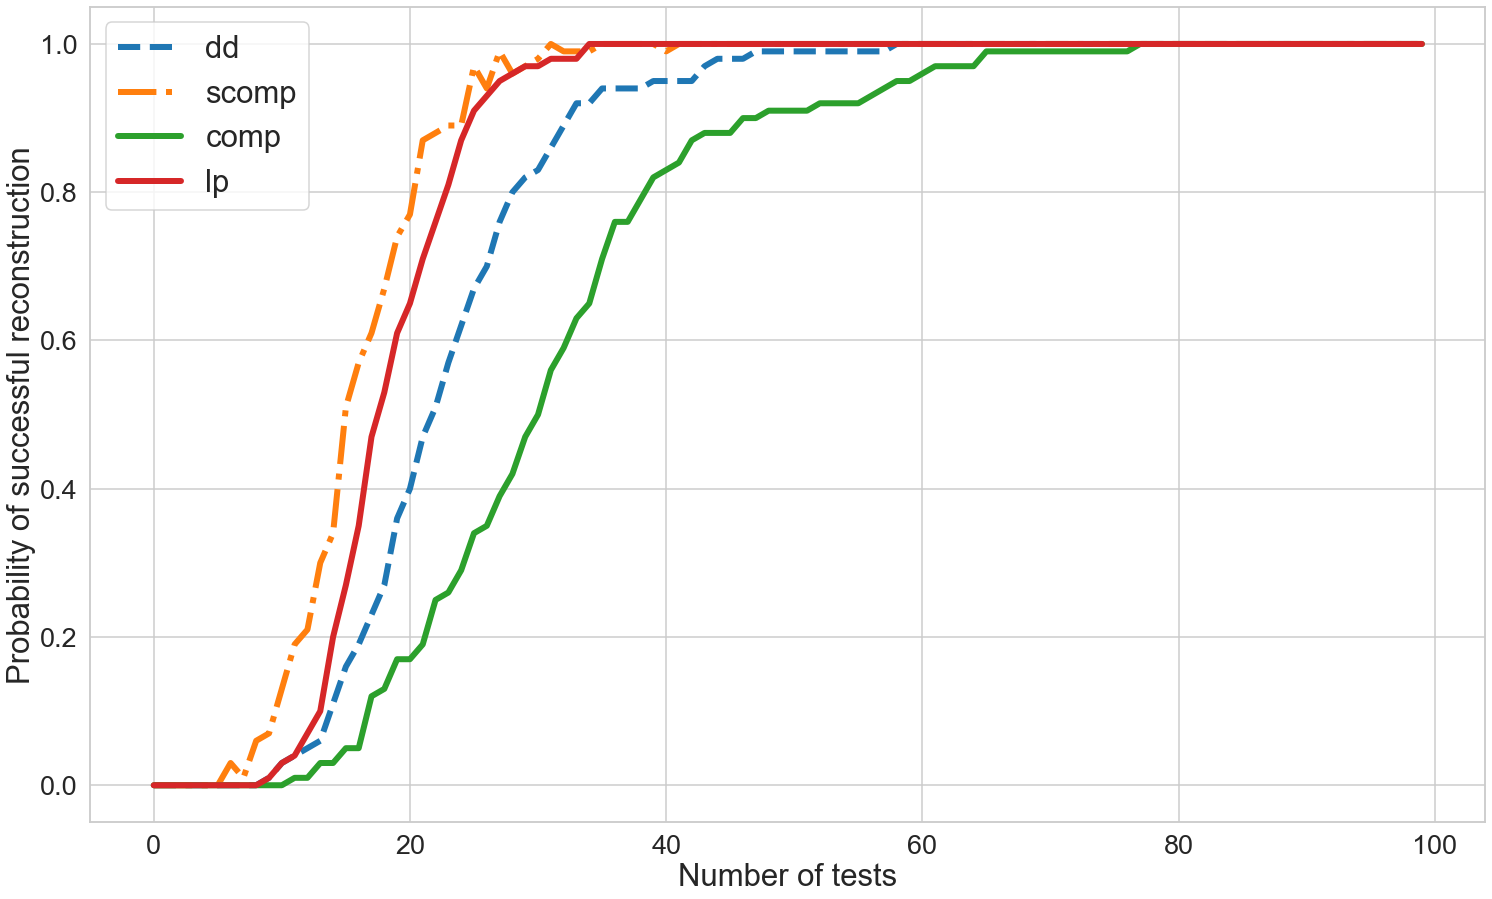

In [72]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(dd_f1scores, label='dd',linestyle='--', linewidth=6)
ax.plot(scomp_f1scores, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(comp_f1scores, label = 'comp', linewidth=6)
ax.plot(lp_f1scores,label='lp',linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('F1 score', fontsize='xx-large')
plt.savefig('comparaison_f1_sparse.pdf')
plt.show()

f,ax = plt.subplots(figsize=(25,15))

ax.plot(dd_succes, label='dd',linestyle='--', linewidth=6)
ax.plot(scomp_succes, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(comp_succes, label = 'comp', linewidth=6)
ax.plot(lp_succes, label = 'lp', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of successful reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('comparaison_proba_sparse.pdf')
plt.show()

### Bernoulli vs. CTPI

We test wether designing tests through CTPI improves testing performance. 

In [101]:
#Hyperparameters 

n_tests = 100
k = 2
matrix_L = x_size/(2*k)
x_size = 100
max_test_size = 60

In [102]:
importlib.reload(rec)

comp_f1scores = np.zeros(max_test_size)
comp_succes = np.zeros(max_test_size)
dd_f1scores = np.zeros(max_test_size)
dd_succes = np.zeros(max_test_size)
scomp_f1scores = np.zeros(max_test_size)
scomp_succes = np.zeros(max_test_size)
lp_f1scores= np.zeros(max_test_size)
lp_succes = np.zeros(max_test_size)


for grouptest in tqdm.tqdm(np.arange(n_tests)):
    
    matrix = ctpi_tests(max_test_size,x_size,matrix_L)
    true_x = vsparse_input(x_size,k,0)
    
    for size in np.arange(0,max_test_size):
        
        test_matrix = matrix[0:size+1,:]
        
        comp = rec.COMP(true_x,test_matrix) 
        comp_f1scores[size] += comp.f1score()
        succes = (comp.reconstruct() == true_x).all()
        comp_succes[size] += succes*1
        
        dd = rec.DD(true_x,test_matrix)
        dd_f1scores[size] += dd.f1score()
        succes = (dd.reconstruct() == true_x).all()
        dd_succes[size] += succes*1
        
        scomp = rec.SCOMP(true_x,test_matrix)
        scomp_f1scores[size] += scomp.f1score()
        succes = (scomp.reconstruct() == true_x).all()
        scomp_succes[size] += succes*1
        
        
        lp = rec.LP(true_x,test_matrix)
        lp_f1scores[size] += lp.f1score()
        succes = (lp.reconstruct() == true_x).all()
        lp_succes[size] += succes*1

comp_f1scores *= 1/n_tests
comp_succes *= 1/n_tests
scomp_f1scores *= 1/n_tests
scomp_succes *= 1/n_tests
dd_f1scores *= 1/n_tests
dd_succes *= 1/n_tests
lp_f1scores *= 1/n_tests
lp_succes *= 1/n_tests
        

100%|██████████| 100/100 [04:05<00:00,  2.45s/it]


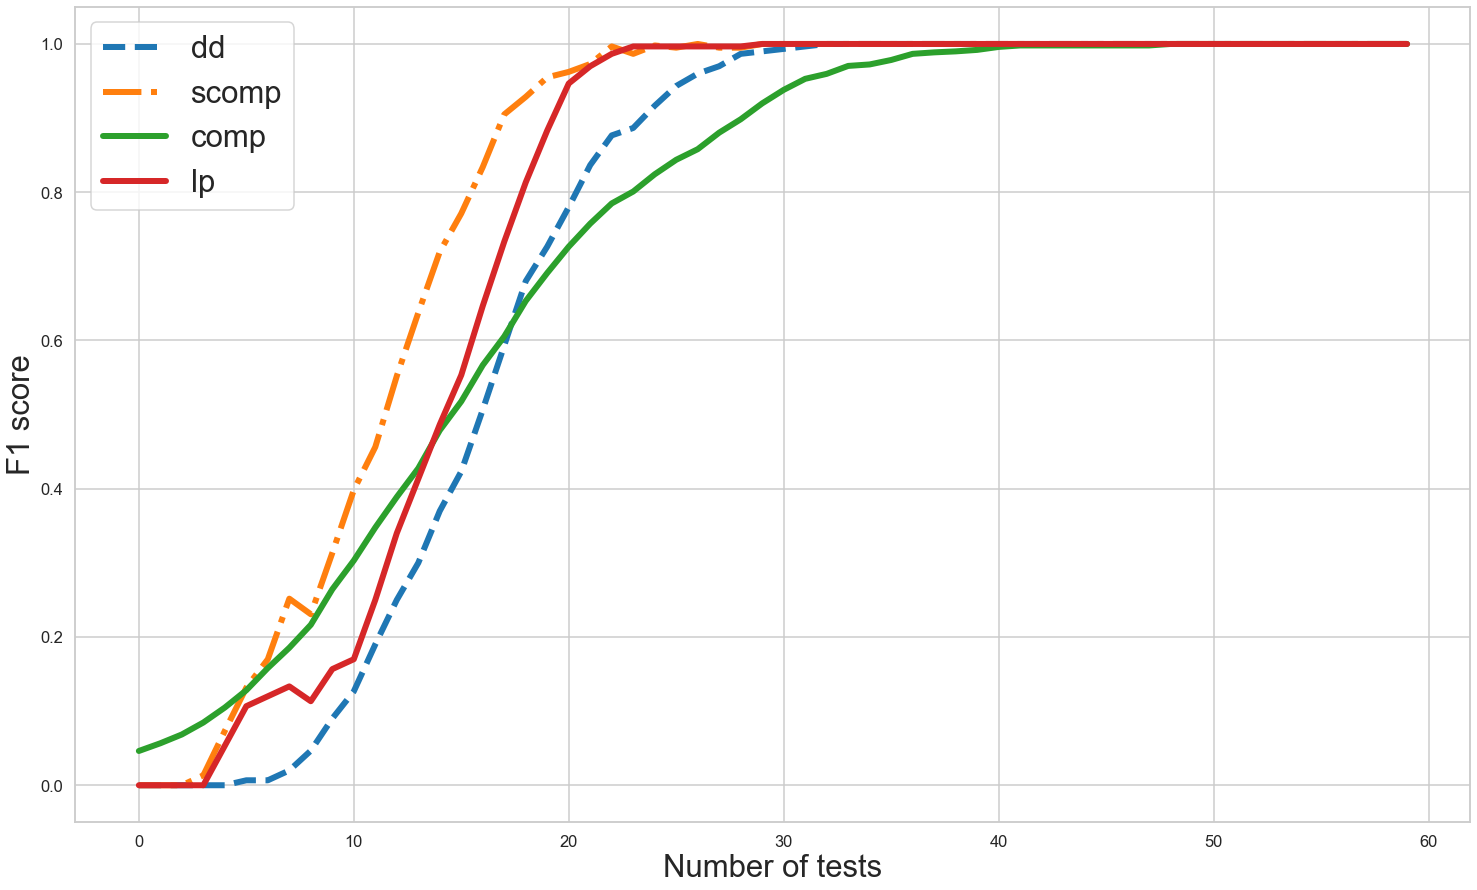

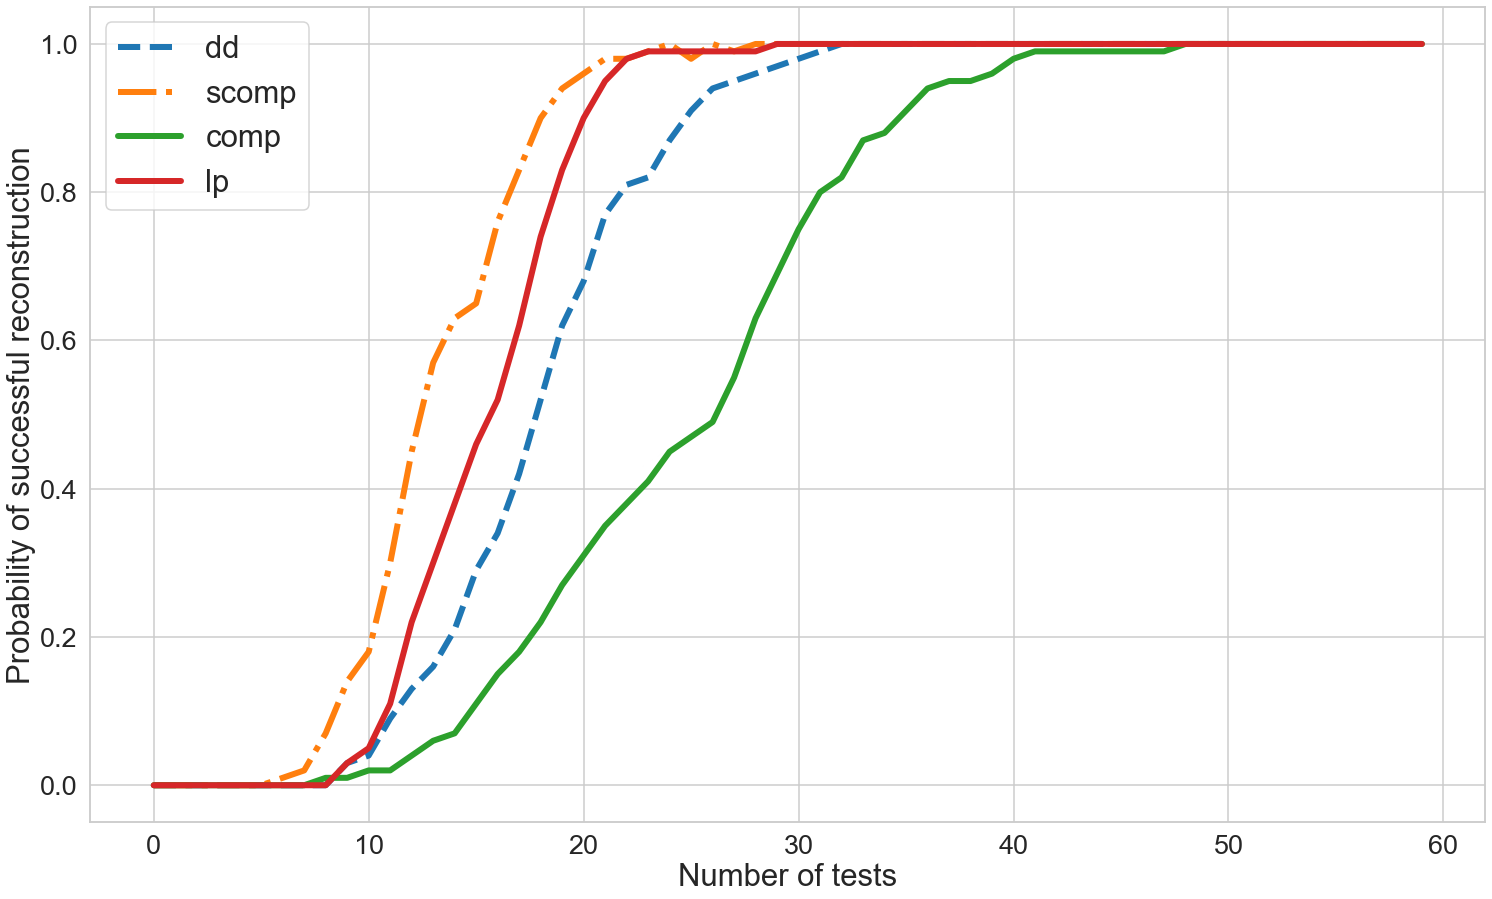

In [105]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(dd_f1scores, label='dd',linestyle='--', linewidth=6)
ax.plot(scomp_f1scores, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(comp_f1scores, label = 'comp', linewidth=6)
ax.plot(lp_f1scores,label='lp',linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('F1 score', fontsize='xx-large')
#plt.savefig('comparaison_f1_cpti.pdf')
plt.show()

f,ax = plt.subplots(figsize=(25,15))

ax.plot(dd_succes, label='dd',linestyle='--', linewidth=6)
ax.plot(scomp_succes, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(comp_succes, label = 'comp', linewidth=6)
ax.plot(lp_succes, label = 'lp', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of successful reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('comparaison_proba_cpti.pdf')
plt.show()

### Asymptotics

In [76]:
#very sparse regime

min_x_size = 50
max_x_size = 300
step = 10
n_simu = 200
n_tests = 40
k = 4

In [78]:
comp_succes_vs = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
dd_succes_vs = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
scomp_succes_vs = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
lp_succes_vs = np.zeros(len(np.arange(min_x_size,max_x_size,step)))

i=0

for size in tqdm.tqdm(np.arange(min_x_size,max_x_size,step)):
    
    for test in np.arange(n_simu):
        
        true_x = vsparse_input(size,k,0)
        test_matrix = b_tests(n_tests,size,1/k)
        
        comp = rec.COMP(true_x,test_matrix) 
        succes = (comp.reconstruct() == true_x).all()
        comp_succes_vs[i] += succes*1
        
        dd = rec.DD(true_x,test_matrix)
        succes = (dd.reconstruct() == true_x).all()
        dd_succes_vs[i] += succes*1
        
        scomp = rec.SCOMP(true_x,test_matrix)
        succes = (scomp.reconstruct() == true_x).all()
        scomp_succes_vs[i] += succes*1
        
        
        lp = rec.LP(true_x,test_matrix)
        succes = (lp.reconstruct() == true_x).all()
        lp_succes_vs[i] += succes*1
        
    i+=1
        
        
comp_succes_vs *= 1/n_simu
scomp_succes_vs *= 1/n_simu
dd_succes_vs *= 1/n_simu
lp_succes_vs *= 1/n_simu
        

100%|██████████| 25/25 [01:14<00:00,  2.97s/it]


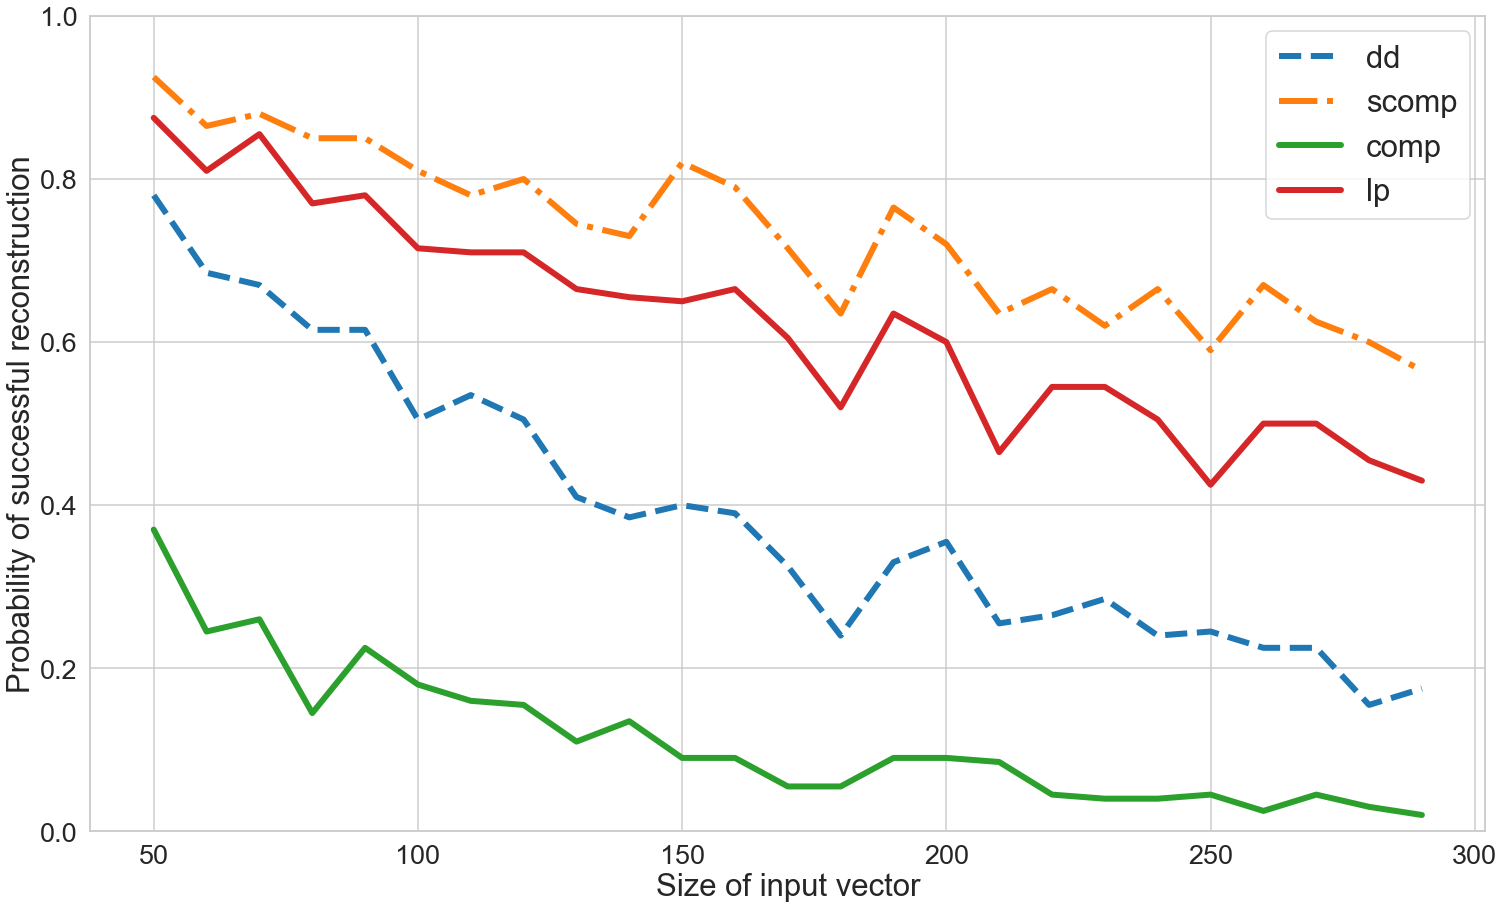

In [83]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

points = np.arange(min_x_size,max_x_size,step)
ax.plot(points,dd_succes_vs, label='dd',linestyle='--', linewidth=6)
ax.plot(points,scomp_succes_vs, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(points,comp_succes_vs, label = 'comp', linewidth=6)
ax.plot(points,lp_succes_vs, label = 'lp', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Size of input vector', fontsize='xx-large')
ax.set_ylabel('Probability of successful reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
ax.set_ylim(0,1)
plt.savefig('proba_very_sparse_regime.pdf')
plt.show()

In [71]:
#sparse regime

min_x_size = 50
max_x_size = 300
step = 10
n_simu = 200
n_tests = 40
k = 1/3

In [72]:
comp_succes_s = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
dd_succes_s = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
scomp_succes_s = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
lp_succes_s = np.zeros(len(np.arange(min_x_size,max_x_size,step)))

i=0

for size in tqdm.tqdm(np.arange(min_x_size,max_x_size,step)):
    
    for test in np.arange(n_simu):
        
        true_x = sparse_input(size,k)
        matproba = 1/np.count_nonzero(true_x)
        test_matrix = b_tests(n_tests,size,matproba)
        
        comp = rec.COMP(true_x,test_matrix) 
        succes = (comp.reconstruct() == true_x).all()
        comp_succes_s[i] += succes*1
        
        dd = rec.DD(true_x,test_matrix)
        succes = (dd.reconstruct() == true_x).all()
        dd_succes_s[i] += succes*1
        
        scomp = rec.SCOMP(true_x,test_matrix)
        succes = (scomp.reconstruct() == true_x).all()
        scomp_succes_s[i] += succes*1
        
        
        lp = rec.LP(true_x,test_matrix)
        succes = (lp.reconstruct() == true_x).all()
        lp_succes_s[i] += succes*1
        
    i+=1
        
        
comp_succes_s *= 1/n_simu
scomp_succes_s *= 1/n_simu
dd_succes_s *= 1/n_simu
lp_succes_s *= 1/n_simu

100%|██████████| 25/25 [01:24<00:00,  3.38s/it]


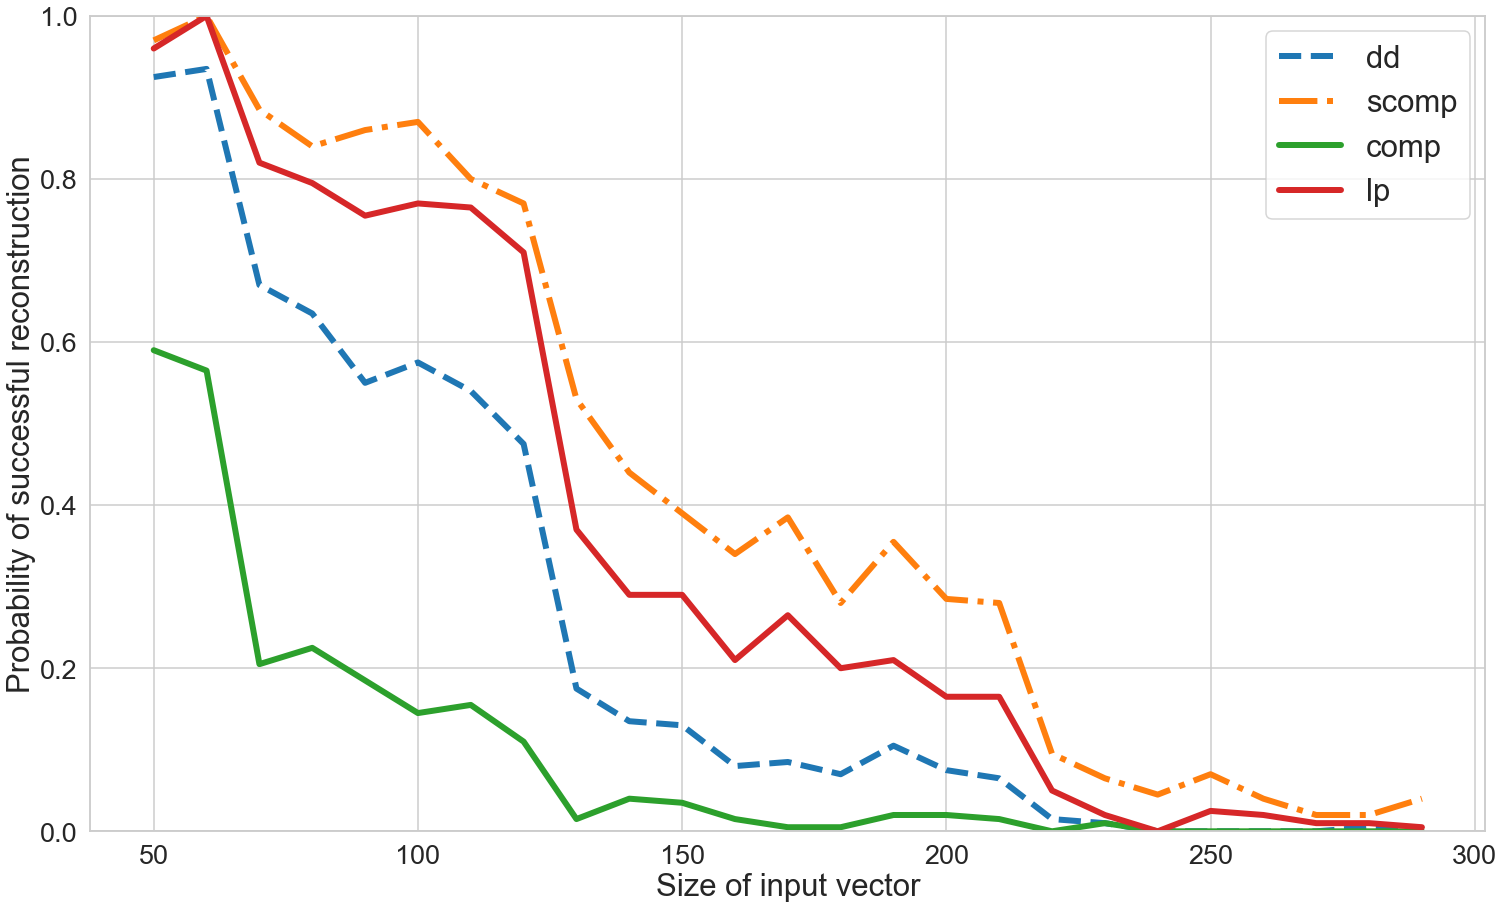

In [82]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))


points = np.arange(min_x_size,max_x_size,step)
ax.plot(points,dd_succes_s, label='dd',linestyle='--', linewidth=6)
ax.plot(points,scomp_succes_s, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(points,comp_succes_s, label = 'comp', linewidth=6)
ax.plot(points,lp_succes_s, label = 'lp', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Size of input vector', fontsize='xx-large')
ax.set_ylabel('Probability of successful reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
ax.set_ylim(0,1)
plt.savefig('proba_sparse_regime.pdf')
plt.show()

In [ ]:
#linear regime 

min_x_size = 50
max_x_size = 300
step = 10
n_simu = 200
n_tests = 40
beta = 0.05

In [84]:
comp_succes_l = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
dd_succes_l = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
scomp_succes_l = np.zeros(len(np.arange(min_x_size,max_x_size,step)))
lp_succes_l = np.zeros(len(np.arange(min_x_size,max_x_size,step)))

i=0

for size in tqdm.tqdm(np.arange(min_x_size,max_x_size,step)):
    
    for test in np.arange(n_simu):
        
        true_x = linear_input(size,beta)
        matproba = 1/np.count_nonzero(true_x)
        test_matrix = b_tests(n_tests,size,matproba)
        
        comp = rec.COMP(true_x,test_matrix) 
        succes = (comp.reconstruct() == true_x).all()
        comp_succes_l[i] += succes*1
        
        dd = rec.DD(true_x,test_matrix)
        succes = (dd.reconstruct() == true_x).all()
        dd_succes_l[i] += succes*1
        
        scomp = rec.SCOMP(true_x,test_matrix)
        succes = (scomp.reconstruct() == true_x).all()
        scomp_succes_l[i] += succes*1
        
        
        lp = rec.LP(true_x,test_matrix)
        succes = (lp.reconstruct() == true_x).all()
        lp_succes_l[i] += succes*1
        
    i+=1
        
        
comp_succes_l *= 1/n_simu
scomp_succes_l *= 1/n_simu
dd_succes_l *= 1/n_simu
lp_succes_l *= 1/n_simu

100%|██████████| 25/25 [01:54<00:00,  4.58s/it]


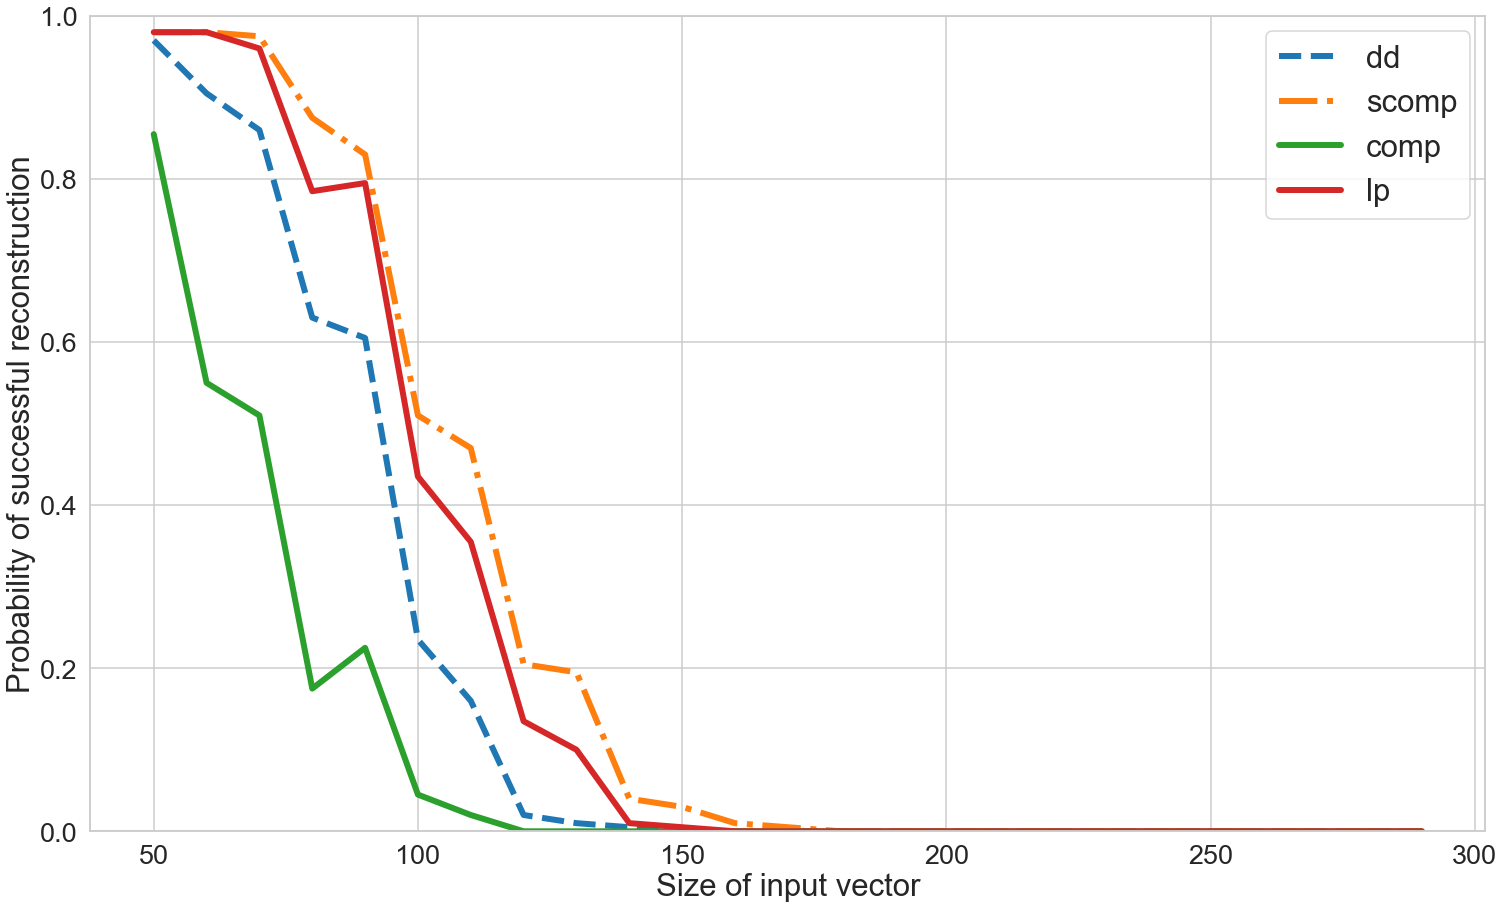

In [85]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))


points = np.arange(min_x_size,max_x_size,step)
ax.plot(points,dd_succes_l, label='dd',linestyle='--', linewidth=6)
ax.plot(points,scomp_succes_l, label ='scomp',linestyle='-.', linewidth=6)
ax.plot(points,comp_succes_l, label = 'comp', linewidth=6)
ax.plot(points,lp_succes_l, label = 'lp', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Size of input vector', fontsize='xx-large')
ax.set_ylabel('Probability of successful reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('proba_linear_regime.pdf')
ax.set_ylim(0,1)
plt.show()

# Group testing with features - a toy example

This section showcases our group testing pipeline on a toy example. 

Consider a classification task, with a dataset that is badly separable by logistic regression, as displayed bellow.

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


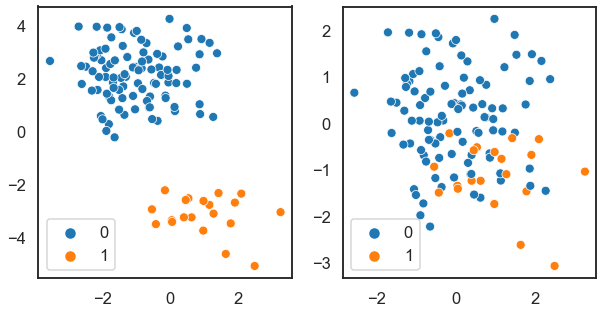

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.datasets import make_blobs

sns.set_style('white')
sns.set_context('talk')

x1, y1 = make_blobs(n_samples=[100,20], n_features=2,
                  random_state=0, centers=np.array([[-1,2],[1,-3]]))
x2, y2 = make_blobs(n_samples=[100,20], n_features=2,
                  random_state=0, centers=np.array([[0,0],[1,-1]]))

f,ax=plt.subplots(1,2,figsize=(10,5))

sns.scatterplot(x1[:,0],x1[:,1],hue=y1,alpha=1, ax=ax[0])
sns.scatterplot(x2[:,0],x2[:,1],hue=y2,alpha=1, ax=ax[1])

plt.legend()
plt.show()

/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


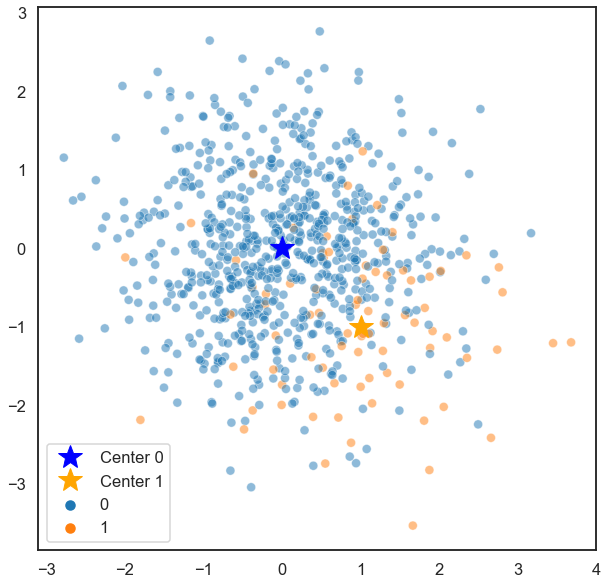

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.datasets import make_blobs

sns.set_context('talk')
sns.set_style('white')

X, y = make_blobs(n_samples=[700,80], n_features=2,
                  random_state=0, centers=np.array([[0,0],[1,-1]]))

f,ax=plt.subplots(figsize=(10,10))

sns.scatterplot(X[:,0],X[:,1],hue=y,alpha=0.5)
plt.plot(0,0,marker='*',markersize=25,c='blue',linestyle='',label='Center 0')
plt.plot(1,-1,marker='*',markersize=25,c='orange',linestyle='',label='Center 1')
plt.legend()
#plt.savefig('toy1data.pdf')
plt.show()


This threshhold selects 16 items for group testing, i.e. 10.256410256410257 percent of the test set.


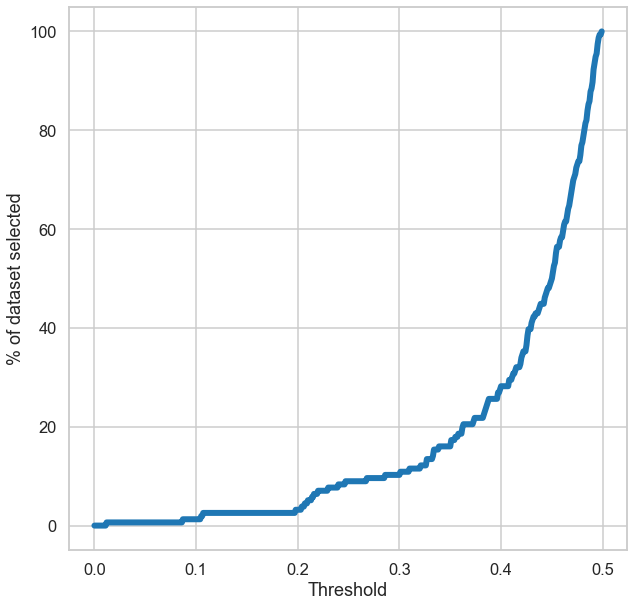

In [12]:
#Select all cases wich are close to the decision boundary

sns.set_context('talk')
sns.set_style('whitegrid')

threshhold = 0.3

points = np.arange(0,0.5,1/1000)

values=[]

for point in points:
    
    suspicious_cases = df[np.abs(df.iloc[:,3]-1/2) < point]
    
    values.append(100*len(suspicious_cases)/len(y_test))

suspicious_cases = df[np.abs(df.iloc[:,3]-1/2) < threshhold]

print('This threshhold selects {} items for group testing, i.e. {} percent of the test set.'.format(len(suspicious_cases),100*len(suspicious_cases)/len(y_test)))

f,ax=plt.subplots(figsize=(10,10))

ax.plot(points,values,linewidth=6)
ax.set_xlabel('Threshold')
ax.set_ylabel('% of dataset selected')
#plt.savefig('thresholdpercentage.pdf')
plt.show()


/Users/linusbleistein/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


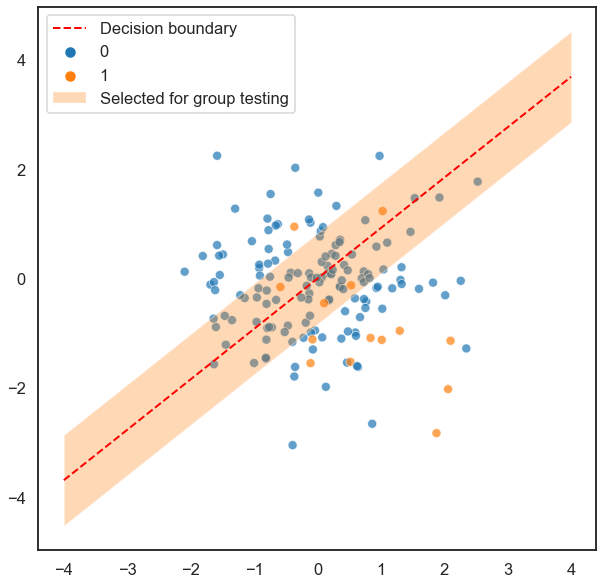

In [13]:
param1 = clf.coef_[0,0]
param2 = clf.coef_[0,1]
threshhold = 0.2

sns.set_context('talk')
sns.set_style('white')

f,ax=plt.subplots(figsize=(10,10))

points = np.arange(start=-4,stop=4,step=0.001)
y_plus = 1/param2*(np.log((1-2*threshhold)/(1+2*threshhold))-param1*points)
y_minus = 1/param2*(np.log((1+2*threshhold)/(1-2*threshhold))-param1*points)
sns.lineplot(x=points,y=1/param2*(-param1*points),linestyle='--',linewidth=2,color='red',label='Decision boundary')
#sns.scatterplot(X[:,0],X[:,1],hue=y,alpha=0.7)
sns.scatterplot(x_test[:,0],x_test[:,1],hue=y_test,alpha=0.7)
ax.fill_between(points,y_minus,y_plus,alpha=0.3,label='Selected for group testing')
#plt.axis('square')
plt.legend()
#plt.savefig('toy1testing.pdf')
plt.show()

### First comparaison between enhanced and vanilla group testing

In [61]:
importlib.reload(rec)

n_tests = 150
max_test_size = 50
samplesize= 400
threshold = 0.39
err = 5
z = 5

enhanced_dd_succes = np.zeros(max_test_size)
dd_succes = np.zeros(max_test_size)
enhanced_dd_errors = np.zeros(max_test_size)
dd_errors = np.zeros(max_test_size)


comp_succes = np.zeros(max_test_size)
enhanced_comp_succes = np.zeros(max_test_size)
comp_errors = np.zeros(max_test_size)
enhanced_comp_errors = np.zeros(max_test_size)


scomp_succes = np.zeros(max_test_size)
enhanced_scomp_succes = np.zeros(max_test_size)
scomp_errors = np.zeros(max_test_size)
enhanced_scomp_errors = np.zeros(max_test_size)

lp_succes = np.zeros(max_test_size)
enhanced_lp_succes = np.zeros(max_test_size)
lp_errors = np.zeros(max_test_size)
enhanced_lp_errors = np.zeros(max_test_size)

for test in tqdm.tqdm(np.arange(n_tests)): 
    
    data = generate_blobs(samplesize,sparsity_regime="vsparse",sparsity_parameter=40)
    
    full_sample_y = data["True status"]
    
    full_rectified = data["Rectified status"]
    
    full_predicted = data["Predicted status"]
    
    suspicious_cases = data[np.abs(data.iloc[:,3]-1/2) < threshold]
    
    suspicious_y = suspicious_cases.iloc[:,0]
    
    k = np.count_nonzero(full_sample_y)
    
    p = 1/k
    
    k_enhanced = np.count_nonzero(suspicious_y)
    
    if k_enhanced == 0:
        
        p_enhanced = p
        
    else:
    
        p_enhanced = 1/k_enhanced
    
    enhanced_matrix = b_tests(max_test_size,len(suspicious_y),p_enhanced)
    
    full_matrix = b_tests(max_test_size,len(full_sample_y),p)
    
    for size in np.arange(z,max_test_size):
        
        full_rectified = data["Rectified status"]
        
        enhanced_test_matrix = enhanced_matrix[0:size+1,:]
        test_matrix = full_matrix[0:size+1,:]

        dd = rec.DD(full_sample_y,test_matrix)
        succes = (dd.reconstruct() == full_sample_y).all()
        dd_succes[size] += succes*1
        dd_errors[size] += error_count(full_sample_y,dd.reconstruct(),err)
        
        
        comp = rec.COMP(full_sample_y,test_matrix)
        succes = (comp.reconstruct() == full_sample_y).all()
        comp_succes[size] += succes*1
        comp_errors[size] += error_count(full_sample_y,comp.reconstruct(),err)
        
        scomp = rec.SCOMP(full_sample_y,test_matrix)
        succes = (scomp.reconstruct() == full_sample_y).all()
        scomp_succes[size] += succes*1
        scomp_errors[size] += error_count(full_sample_y,scomp.reconstruct(),err)
        
        lp = rec.LP(full_sample_y,test_matrix)
        succes = (lp.reconstruct() == full_sample_y).all()
        lp_succes[size] += succes*1
        lp_errors[size] += error_count(full_sample_y,scomp.reconstruct(),err)
        
        
        enhanced_dd = rec.DD(suspicious_y,enhanced_test_matrix)
        enhanced_comp = rec.COMP(suspicious_y,enhanced_test_matrix)
        enhanced_scomp = rec.SCOMP(suspicious_y,enhanced_test_matrix)
        enhanced_lp = rec.LP(suspicious_y,enhanced_test_matrix)
        
        dd_reconstructed_suspicious = enhanced_dd.reconstruct()
        comp_reconstructed_suspicious = enhanced_comp.reconstruct()
        scomp_reconstructed_suspicious = enhanced_scomp.reconstruct()
        lp_reconstructed_suspicious = enhanced_lp.reconstruct()
        
        #enhanced comp metrics
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = comp_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_comp_succes[size] += succes*1
        enhanced_comp_errors[size] += error_count(full_rectified,full_sample_y,err)
            
        #enhanced dd metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = dd_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_dd_succes[size] += succes*1
        enhanced_dd_errors[size] += error_count(full_rectified,full_sample_y,err)
        
        #enhanced scomp metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = scomp_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_scomp_succes[size] += succes*1
        enhanced_scomp_errors[size] += error_count(full_rectified,full_sample_y,err)
        
        #enhanced lp metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = lp_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_lp_succes[size] += succes*1
        enhanced_lp_errors[size] += error_count(full_rectified,full_sample_y,err)


enhanced_dd_succes *= 1/n_tests
enhanced_comp_succes *= 1/n_tests
enhanced_scomp_succes *= 1/n_tests
enhanced_lp_succes *= 1/n_tests

enhanced_dd_errors *= 1/n_tests
enhanced_comp_errors *= 1/n_tests
enhanced_scomp_errors *= 1/n_tests
enhanced_lp_errors *= 1/n_tests

dd_succes *= 1/n_tests
comp_succes *= 1/n_tests
scomp_succes *= 1/n_tests
lp_succes *= 1/n_tests

dd_errors *= 1/n_tests
comp_errors *= 1/n_tests
scomp_errors *= 1/n_tests
lp_errors *= 1/n_tests

    
    
    

  5%|▌         | 8/150 [00:19<05:33,  2.35s/it]

klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong


 18%|█▊        | 27/150 [01:04<04:24,  2.15s/it]

klong


 45%|████▌     | 68/150 [02:26<02:35,  1.90s/it]

klong
klong


 47%|████▋     | 71/150 [02:32<02:27,  1.87s/it]

klong
klong
klong
klong


 53%|█████▎    | 80/150 [02:49<02:22,  2.03s/it]

klong


100%|██████████| 150/150 [35:17<00:00, 14.12s/it]   


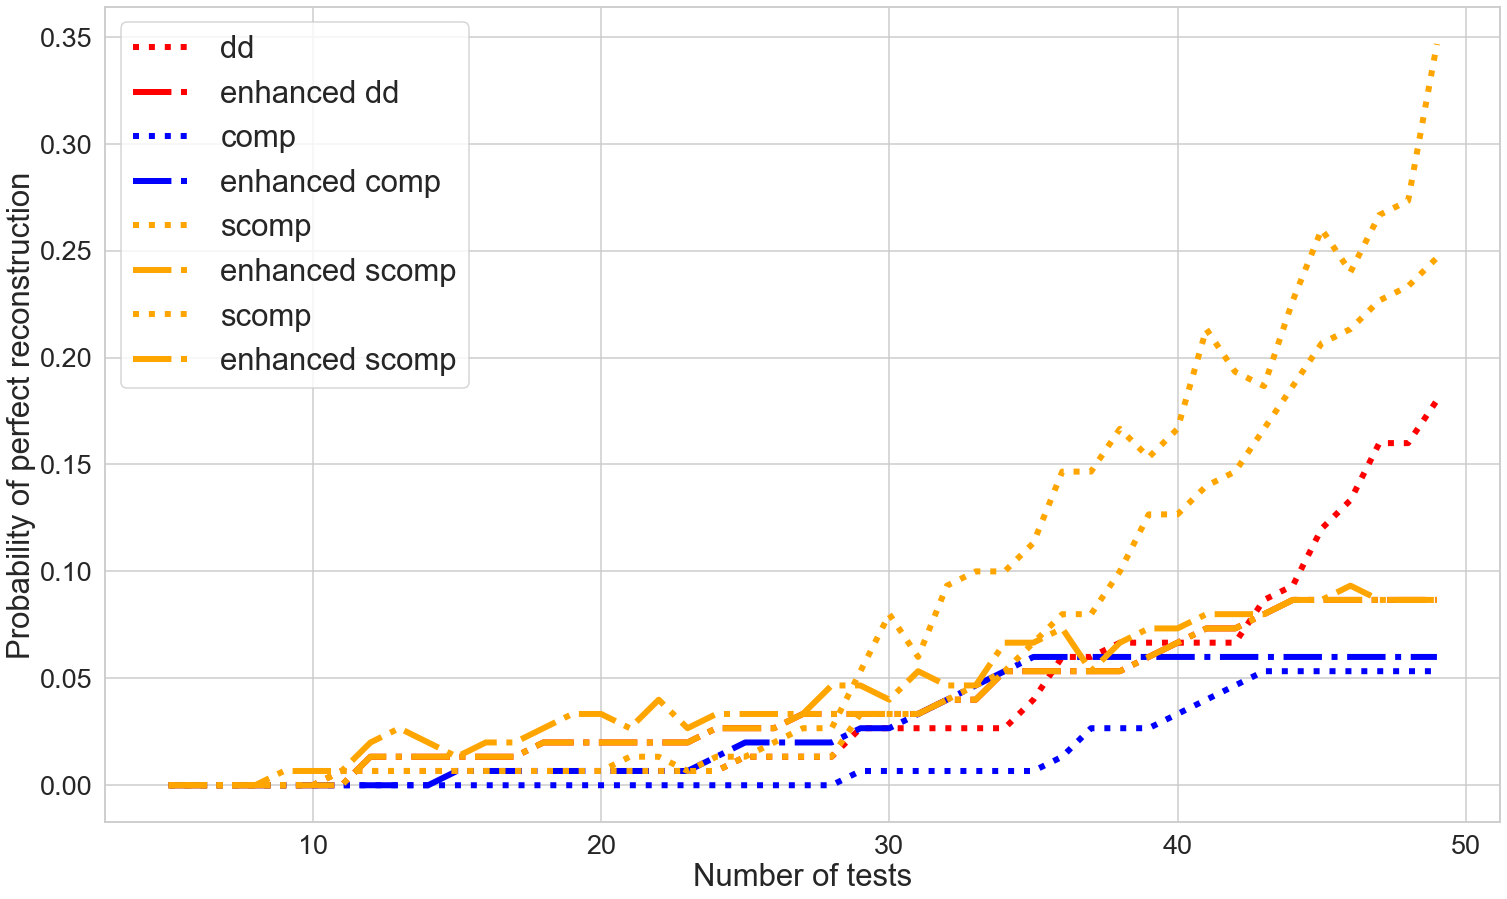

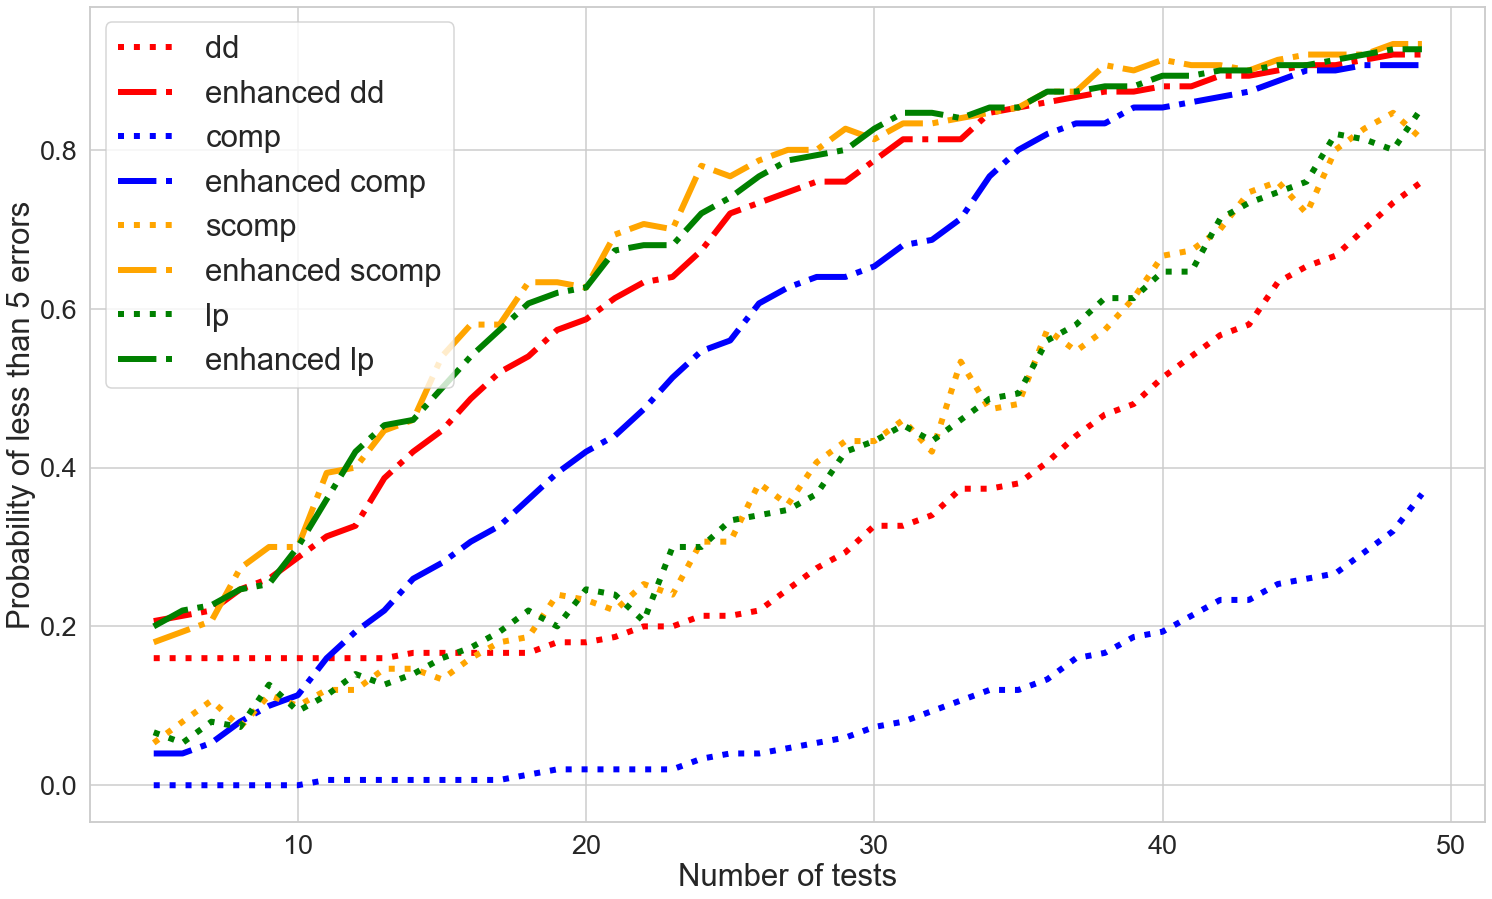

In [64]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_succes[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_succes[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_succes[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_succes[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_succes[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_succes[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_succes[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_succes[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of perfect reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('toy1threshold39perfect_n400_k40.pdf')

plt.show()

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_errors[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_errors[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_errors[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_errors[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_errors[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_errors[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_errors[z:], label='lp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_errors[z:], label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of less than 5 errors', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('toy1threshold39_5errs_n400_k40.pdf')

plt.show()


In [11]:
importlib.reload(rec)

n_tests = 150
max_test_size = 50
samplesize= 400
threshold = 0.39
err = 5
z = 5
test_size = len(np.arange(z,max_test_size))

enhanced_dd_nerr = np.zeros(test_size)
dd_nerr = np.zeros(test_size)


comp_nerr = np.zeros(test_size)
enhanced_comp_nerr = np.zeros(test_size)



scomp_nerr = np.zeros(test_size)
enhanced_scomp_nerr = np.zeros(test_size)


lp_nerr = np.zeros(test_size)
enhanced_lp_nerr = np.zeros(test_size)


for test in tqdm.tqdm(np.arange(n_tests)): 
    
    data = generate_blobs(samplesize,sparsity_regime="vsparse",sparsity_parameter=40)
    
    full_sample_y = data["True status"]
    
    full_rectified = data["Rectified status"]
    
    full_predicted = data["Predicted status"]
    
    suspicious_cases = data[np.abs(data.iloc[:,3]-1/2) < threshold]
    
    suspicious_y = suspicious_cases.iloc[:,0]
    
    k = np.count_nonzero(full_sample_y)
    
    p = 1/k
    
    k_enhanced = np.count_nonzero(suspicious_y)
    
    if k_enhanced == 0:
        
        p_enhanced = p
        
    else:
    
        p_enhanced = 1/k_enhanced
    
    enhanced_matrix = b_tests(max_test_size,len(suspicious_y),p_enhanced)
    
    full_matrix = b_tests(max_test_size,len(full_sample_y),p)
    
    for size in np.arange(z,max_test_size):
        
        size=size-z
        full_rectified = data["Rectified status"]
        
        enhanced_test_matrix = enhanced_matrix[0:size+1,:]
        test_matrix = full_matrix[0:size+1,:]

        dd = rec.DD(full_sample_y,test_matrix)
        dd_nerr[size] += error_n(full_sample_y,dd.reconstruct())
        
        
        comp = rec.COMP(full_sample_y,test_matrix)
        comp_nerr[size] += error_n(full_sample_y,comp.reconstruct())
        
        scomp = rec.SCOMP(full_sample_y,test_matrix)
        scomp_nerr[size] += error_n(full_sample_y,scomp.reconstruct())
        
        lp = rec.LP(full_sample_y,test_matrix)
        lp_nerr[size] += error_n(full_sample_y,lp.reconstruct())
        
        
        enhanced_dd = rec.DD(suspicious_y,enhanced_test_matrix)
        enhanced_comp = rec.COMP(suspicious_y,enhanced_test_matrix)
        enhanced_scomp = rec.SCOMP(suspicious_y,enhanced_test_matrix)
        enhanced_lp = rec.LP(suspicious_y,enhanced_test_matrix)
        
        dd_reconstructed_suspicious = enhanced_dd.reconstruct()
        comp_reconstructed_suspicious = enhanced_comp.reconstruct()
        scomp_reconstructed_suspicious = enhanced_scomp.reconstruct()
        lp_reconstructed_suspicious = enhanced_lp.reconstruct()
        
        #enhanced comp metrics
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = comp_reconstructed_suspicious
        enhanced_comp_nerr[size] += error_n(full_rectified,full_sample_y)
            
        #enhanced dd metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = dd_reconstructed_suspicious
        enhanced_dd_nerr[size] += error_n(full_rectified,full_sample_y)
        
        #enhanced scomp metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = scomp_reconstructed_suspicious
        enhanced_scomp_nerr[size] += error_n(full_rectified,full_sample_y)
        
        #enhanced lp metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < threshold] = lp_reconstructed_suspicious
        enhanced_lp_nerr[size] += error_n(full_rectified,full_sample_y)

enhanced_dd_nerr *= 1/n_tests 
dd_nerr *= 1/n_tests


comp_nerr *= 1/n_tests
enhanced_comp_nerr *= 1/n_tests



scomp_nerr *= 1/n_tests
enhanced_scomp_nerr *= 1/n_tests


lp_nerr *= 1/n_tests
enhanced_lp_nerr *= 1/n_tests


 15%|█▌        | 23/150 [00:34<03:06,  1.47s/it]

klong
klong


 21%|██▏       | 32/150 [00:48<03:08,  1.60s/it]

klong


 38%|███▊      | 57/150 [01:24<02:31,  1.63s/it]

klong
klong
klong


 49%|████▊     | 73/150 [01:49<01:54,  1.49s/it]

klong
klong
klong


 49%|████▉     | 74/150 [01:50<01:56,  1.54s/it]

klong


 59%|█████▉    | 89/150 [02:15<01:35,  1.57s/it]

klong
klong
klong
klong


 61%|██████    | 91/150 [02:18<01:35,  1.61s/it]

klong


 61%|██████▏   | 92/150 [02:20<01:36,  1.67s/it]

klong
klong
klong


 82%|████████▏ | 123/150 [03:09<00:43,  1.62s/it]

klong


 83%|████████▎ | 125/150 [03:13<00:40,  1.61s/it]

klong
klong
klong
klong
klong


 85%|████████▌ | 128/150 [03:18<00:34,  1.59s/it]

klong


 93%|█████████▎| 140/150 [03:38<00:17,  1.73s/it]

klong
klong


100%|██████████| 150/150 [03:53<00:00,  1.56s/it]


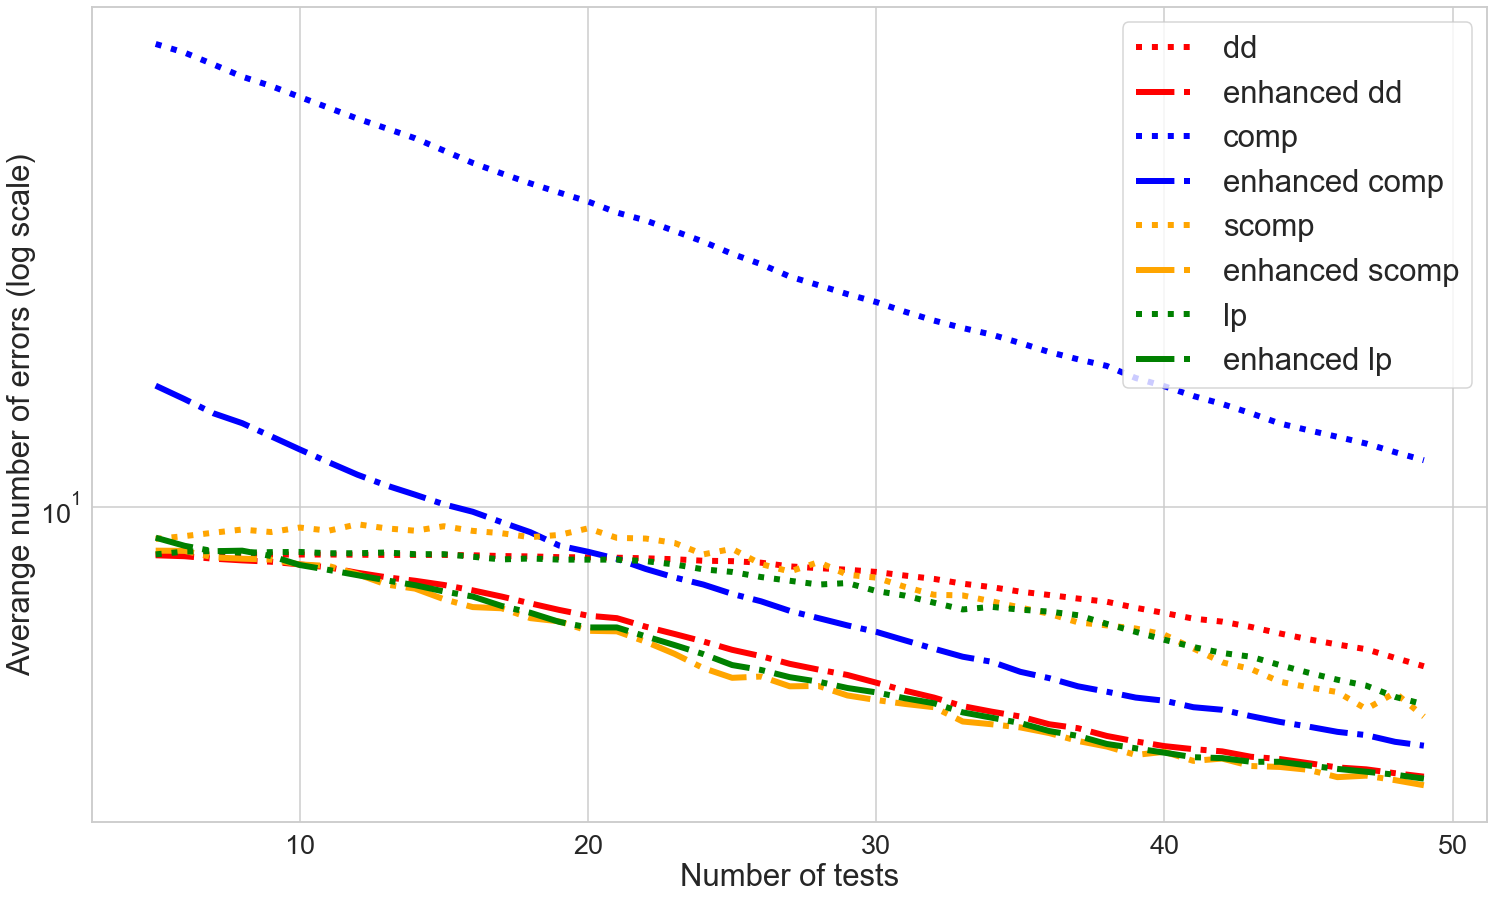

In [17]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_nerr, label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_nerr, label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_nerr, label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_nerr, label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_nerr, label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_nerr, label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_nerr, label='lp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_nerr, label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Averange number of errors (log scale)', fontsize='xx-large')
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('av_err_n400_k40.pdf')

plt.show()

In [28]:
importlib.reload(rec)

n_tests = 150
test_number = 40
samplesize= 400
thresholds = np.arange(0.1,0.49,1/100)
thr_length = len(thresholds)
err = 5

enhanced_dd_thr = np.zeros(thr_length)
dd_thr = np.zeros(thr_length)


comp_thr = np.zeros(thr_length)
enhanced_comp_thr = np.zeros(thr_length)



scomp_thr= np.zeros(thr_length)
enhanced_scomp_thr = np.zeros(thr_length)


lp_thr = np.zeros(thr_length)
enhanced_lp_thr = np.zeros(thr_length)


for test in tqdm.tqdm(np.arange(n_tests)): 
    
    data = generate_blobs(samplesize,sparsity_regime="vsparse",sparsity_parameter=40)
    
    full_sample_y = data["True status"]
    
    full_rectified = data["Rectified status"]
    
    full_predicted = data["Predicted status"]
    
    suspicious_cases = data[np.abs(data.iloc[:,3]-1/2) < threshold]
    
    suspicious_y = suspicious_cases.iloc[:,0]
    
    #k = np.count_nonzero(full_sample_y)
    
    #p = 1/k
        
    #full_matrix = b_tests(max_test_size,len(full_sample_y),p)
    
    for i,thresh in enumerate(thresholds):
        
        suspicious_cases = data[np.abs(data.iloc[:,3]-1/2) < thresh]
    
        suspicious_y = suspicious_cases.iloc[:,0]
        
        k_enhanced = np.count_nonzero(suspicious_y)
        
        enhanced_matrix = b_tests(test_number,len(suspicious_y),p_enhanced)
    
        if k_enhanced == 0:
        
            p_enhanced = p
        
        else:
    
            p_enhanced = 1/k_enhanced
        
        full_rectified = data["Rectified status"]
        
        enhanced_test_matrix = enhanced_matrix
        #test_matrix = full_matrix

        #dd = rec.DD(full_sample_y,test_matrix)
        #dd_nerr[size] += error_n(full_sample_y,dd.reconstruct())
        
        
        #comp = rec.COMP(full_sample_y,test_matrix)
        #comp_nerr[size] += error_n(full_sample_y,comp.reconstruct())
        
        #scomp = rec.SCOMP(full_sample_y,test_matrix)
        #scomp_nerr[size] += error_n(full_sample_y,scomp.reconstruct())
        
        #lp = rec.LP(full_sample_y,test_matrix)
        #lp_nerr[size] += error_n(full_sample_y,lp.reconstruct())
        
        
        enhanced_dd = rec.DD(suspicious_y,enhanced_test_matrix)
        enhanced_comp = rec.COMP(suspicious_y,enhanced_test_matrix)
        enhanced_scomp = rec.SCOMP(suspicious_y,enhanced_test_matrix)
        enhanced_lp = rec.LP(suspicious_y,enhanced_test_matrix)
        
        dd_reconstructed_suspicious = enhanced_dd.reconstruct()
        comp_reconstructed_suspicious = enhanced_comp.reconstruct()
        scomp_reconstructed_suspicious = enhanced_scomp.reconstruct()
        lp_reconstructed_suspicious = enhanced_lp.reconstruct()
        
        #enhanced comp metrics
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < thresh] = comp_reconstructed_suspicious
        enhanced_comp_thr[i] += error_n(full_rectified,full_sample_y)
            
        #enhanced dd metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < thresh] = dd_reconstructed_suspicious
        enhanced_dd_thr[i] += error_n(full_rectified,full_sample_y)
        
        #enhanced scomp metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < thresh] = scomp_reconstructed_suspicious
        enhanced_scomp_thr[i] += error_n(full_rectified,full_sample_y)
        
        #enhanced lp metrics 
        
        full_rectified[np.abs(data.iloc[:,3]-1/2) < thresh] = lp_reconstructed_suspicious
        enhanced_lp_thr[i] += error_n(full_rectified,full_sample_y)

enhanced_dd_thr *= 1/n_tests 
dd_thr *= 1/n_tests


comp_thr *= 1/n_tests
enhanced_comp_thr *= 1/n_tests



scomp_thr *= 1/n_tests
enhanced_scomp_thr *= 1/n_tests


lp_thr *= 1/n_tests
enhanced_lp_thr *= 1/n_tests

  5%|▌         | 8/150 [00:05<01:43,  1.37it/s]

klong


  6%|▌         | 9/150 [00:06<01:42,  1.38it/s]

klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong


  8%|▊         | 12/150 [00:09<01:51,  1.23it/s]

klong
klong


 12%|█▏        | 18/150 [00:13<01:40,  1.32it/s]

klong
klong
klong


 18%|█▊        | 27/150 [00:20<01:32,  1.32it/s]

klong


 20%|██        | 30/150 [00:23<01:34,  1.26it/s]

klong


 21%|██        | 31/150 [00:23<01:33,  1.27it/s]

klong


 23%|██▎       | 34/150 [00:26<01:33,  1.24it/s]

klong


 25%|██▍       | 37/150 [00:28<01:32,  1.22it/s]

klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong


 33%|███▎      | 49/150 [00:38<01:16,  1.32it/s]

klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong


 42%|████▏     | 63/150 [00:49<01:10,  1.23it/s]

klong
klong


 46%|████▌     | 69/150 [00:54<01:14,  1.09it/s]

klong


 50%|█████     | 75/150 [00:59<01:02,  1.20it/s]

klong


 52%|█████▏    | 78/150 [01:02<00:57,  1.25it/s]

klong


 59%|█████▊    | 88/150 [01:09<00:44,  1.39it/s]

klong
klong


 59%|█████▉    | 89/150 [01:10<00:43,  1.39it/s]

klong
klong
klong
klong
klong


 65%|██████▍   | 97/150 [01:16<00:37,  1.41it/s]

klong


 65%|██████▌   | 98/150 [01:16<00:36,  1.41it/s]

klong


 66%|██████▌   | 99/150 [01:17<00:35,  1.42it/s]

klong
klong
klong


 69%|██████▊   | 103/150 [01:20<00:33,  1.40it/s]

klong
klong
klong
klong


 78%|███████▊  | 117/150 [01:31<00:25,  1.28it/s]

klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong


 84%|████████▍ | 126/150 [01:38<00:18,  1.33it/s]

klong


 87%|████████▋ | 131/150 [01:42<00:13,  1.36it/s]

klong


 89%|████████▊ | 133/150 [01:44<00:12,  1.34it/s]

klong


 91%|█████████ | 136/150 [01:46<00:10,  1.36it/s]

klong


 92%|█████████▏| 138/150 [01:47<00:08,  1.35it/s]

klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong
klong


 99%|█████████▊| 148/150 [01:54<00:01,  1.42it/s]

klong
klong


100%|██████████| 150/150 [01:56<00:00,  1.29it/s]


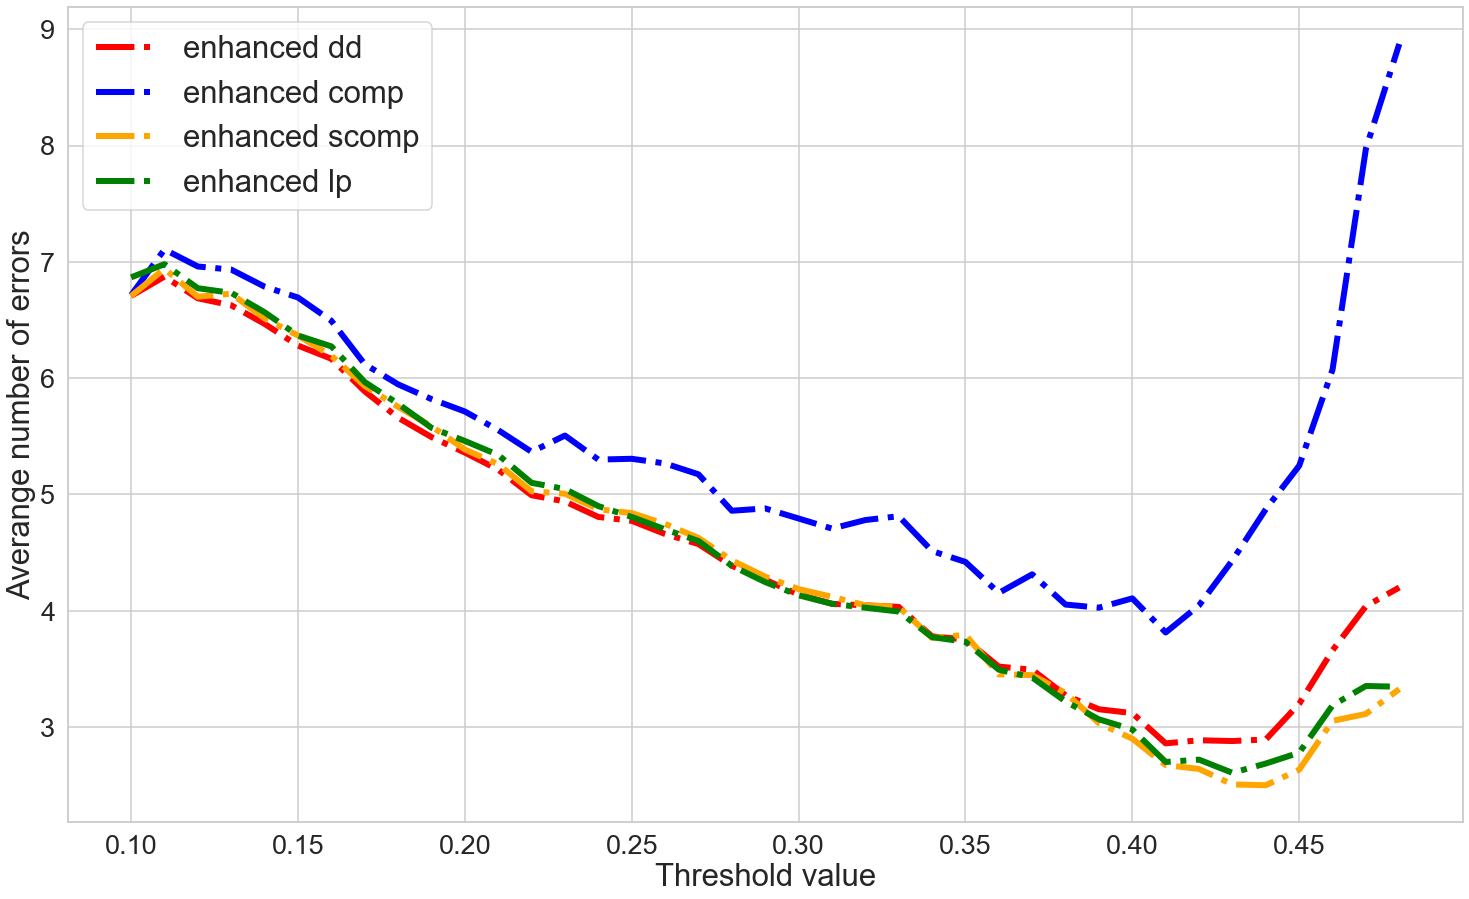

In [36]:
f,ax = plt.subplots(figsize=(25,15))

ax.plot(thresholds,enhanced_dd_thr, label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(thresholds,enhanced_comp_thr, label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(thresholds,enhanced_scomp_thr, label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(thresholds,enhanced_lp_thr, label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Threshold value', fontsize='xx-large')
ax.set_ylabel('Averange number of errors', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('bestthr_n400_k40.pdf')

plt.show()

## Soft thresholding

In [3]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import torch
import sys
import cvxpy as cp
import tqdm
import importlib
import sklearn
import pandas as pd
import reconstruction_alg as rec
from utils import *
importlib.reload(rec)

n_tests = 50
max_test_size = 50
samplesize= 400
threshold = 0.39
err = 5
z = 5

enhanced_dd_succes = np.zeros(max_test_size)
dd_succes = np.zeros(max_test_size)
enhanced_dd_errors = np.zeros(max_test_size)
dd_errors = np.zeros(max_test_size)


comp_succes = np.zeros(max_test_size)
enhanced_comp_succes = np.zeros(max_test_size)
comp_errors = np.zeros(max_test_size)
enhanced_comp_errors = np.zeros(max_test_size)


scomp_succes = np.zeros(max_test_size)
enhanced_scomp_succes = np.zeros(max_test_size)
scomp_errors = np.zeros(max_test_size)
enhanced_scomp_errors = np.zeros(max_test_size)

lp_succes = np.zeros(max_test_size)
enhanced_lp_succes = np.zeros(max_test_size)
lp_errors = np.zeros(max_test_size)
enhanced_lp_errors = np.zeros(max_test_size)

enhanced_dd_nerr = np.zeros(max_test_size)
dd_nerr = np.zeros(max_test_size)


comp_nerr = np.zeros(max_test_size)
enhanced_comp_nerr = np.zeros(max_test_size)



scomp_nerr = np.zeros(max_test_size)
enhanced_scomp_nerr = np.zeros(max_test_size)


lp_nerr = np.zeros(max_test_size)
enhanced_lp_nerr = np.zeros(max_test_size)

for test in tqdm.tqdm(np.arange(n_tests)): 
    
    data = generate_blobs(samplesize,sparsity_regime="vsparse",sparsity_parameter=40)
    
    probas = np.array(data['Predicted probability'])
    
    full_sample_y = data["True status"]
    
    full_rectified = data["Rectified status"]
    
    full_predicted = data["Predicted status"]
    
    k = np.count_nonzero(full_sample_y)
    
    p = 1/k
    
    enhanced_matrix = logistic_tests(max_test_size,probas,k)
    
    full_matrix = b_tests(max_test_size,len(full_sample_y),p)
    
    for size in np.arange(z,max_test_size):
        
        full_rectified = data["Rectified status"]
        
        enhanced_test_matrix = enhanced_matrix[0:size+1,:]
        test_matrix = full_matrix[0:size+1,:]

        dd = rec.DD(full_sample_y,test_matrix)
        succes = (dd.reconstruct() == full_sample_y).all()
        dd_succes[size] += succes*1
        dd_errors[size] += error_count(full_sample_y,dd.reconstruct(),err)
        dd_nerr[size] += error_n(full_sample_y,dd.reconstruct())
        
        
        comp = rec.COMP(full_sample_y,test_matrix)
        succes = (comp.reconstruct() == full_sample_y).all()
        comp_succes[size] += succes*1
        comp_errors[size] += error_count(full_sample_y,comp.reconstruct(),err)
        comp_nerr[size] += error_n(full_sample_y,comp.reconstruct())
        
        scomp = rec.SCOMP(full_sample_y,test_matrix)
        succes = (scomp.reconstruct() == full_sample_y).all()
        scomp_succes[size] += succes*1
        scomp_errors[size] += error_count(full_sample_y,scomp.reconstruct(),err)
        scomp_nerr[size] += error_n(full_sample_y,scomp.reconstruct())
        
        lp = rec.LP(full_sample_y,test_matrix)
        succes = (lp.reconstruct() == full_sample_y).all()
        lp_succes[size] += succes*1
        lp_errors[size] += error_count(full_sample_y,lp.reconstruct(),err)
        
        
        enhanced_dd = rec.DD(full_sample_y,enhanced_test_matrix)
        enhanced_comp = rec.COMP(full_sample_y,enhanced_test_matrix)
        enhanced_scomp = rec.SCOMP(full_sample_y,enhanced_test_matrix)
        enhanced_lp = rec.LP(full_sample_y,enhanced_test_matrix)
        
        enhanced_dd_reconstruct = enhanced_dd.reconstruct()
        enhanced_comp_reconstruct = enhanced_comp.reconstruct()
        enhanced_scomp_reconstruct = enhanced_scomp.reconstruct()
        enhanced_lp_reconstruct = enhanced_lp.reconstruct()
        
        #enhanced comp metrics
        
        succes = (enhanced_comp_reconstruct == full_sample_y).all()
        enhanced_comp_succes[size] += succes*1
        enhanced_comp_errors[size] += error_count(enhanced_comp_reconstruct,full_sample_y,err)
        enhanced_comp_nerr[size] += error_n(enhanced_comp_reconstruct,full_sample_y)
        
            
        #enhanced dd metrics 
        
        succes = (enhanced_dd_reconstruct == full_sample_y).all()
        enhanced_dd_succes[size] += succes*1
        enhanced_dd_errors[size] += error_count(enhanced_dd_reconstruct,full_sample_y,err)
        enhanced_dd_nerr[size] += error_n(enhanced_dd_reconstruct,full_sample_y)
        
        #enhanced scomp metrics 
        
        succes = (enhanced_scomp_reconstruct == full_sample_y).all()
        enhanced_scomp_succes[size] += succes*1
        enhanced_scomp_errors[size] += error_count(enhanced_scomp_reconstruct,full_sample_y,err)
        enhanced_scomp_nerr[size] += error_n(enhanced_scomp_reconstruct,full_sample_y)
        
        #enhanced lp metrics 
        
        succes = (enhanced_lp_reconstruct == full_sample_y).all()
        enhanced_lp_succes[size] += succes*1
        enhanced_lp_errors[size] += error_count(enhanced_lp_reconstruct,full_sample_y,err)

enhanced_dd_succes *= 1/n_tests
enhanced_comp_succes *= 1/n_tests
enhanced_scomp_succes *= 1/n_tests
enhanced_lp_succes *= 1/n_tests

enhanced_dd_errors *= 1/n_tests
enhanced_comp_errors *= 1/n_tests
enhanced_scomp_errors *= 1/n_tests
enhanced_lp_errors *= 1/n_tests

dd_succes *= 1/n_tests
comp_succes *= 1/n_tests
scomp_succes *= 1/n_tests
lp_succes *= 1/n_tests

dd_errors *= 1/n_tests
comp_errors *= 1/n_tests
scomp_errors *= 1/n_tests
lp_errors *= 1/n_tests

enhanced_dd_nerr *= 1/n_tests 
dd_nerr *= 1/n_tests


comp_nerr *= 1/n_tests
enhanced_comp_nerr *= 1/n_tests



scomp_nerr *= 1/n_tests
enhanced_scomp_nerr *= 1/n_tests


lp_nerr *= 1/n_tests
enhanced_lp_nerr *= 1/n_tests


100%|██████████| 50/50 [02:26<00:00,  2.92s/it]


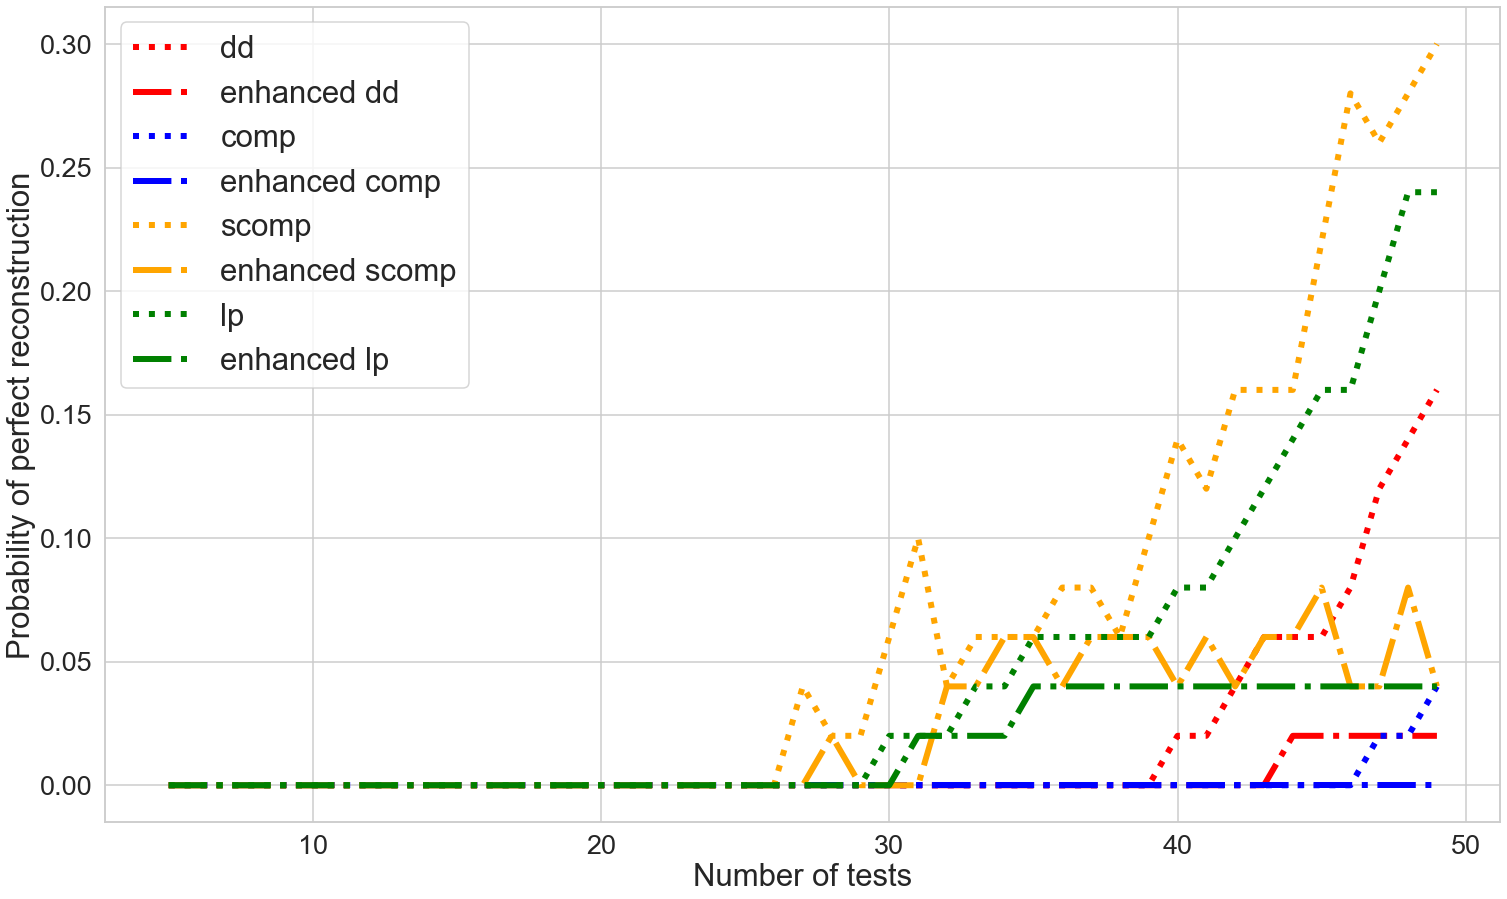

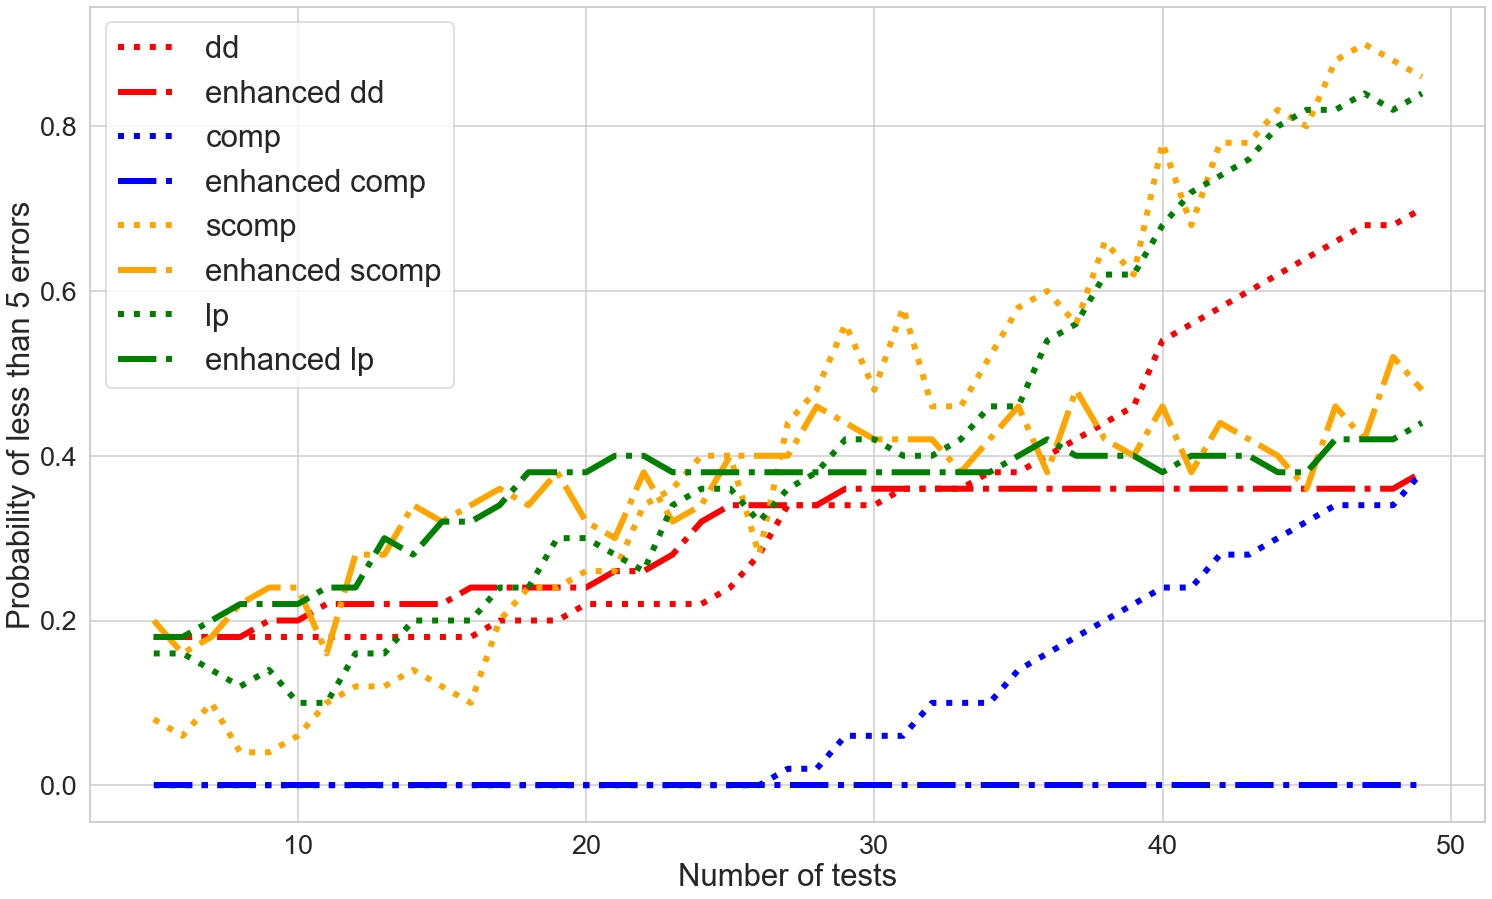

In [5]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_succes[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_succes[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_succes[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_succes[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_succes[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_succes[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_succes[z:], label='lp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_succes[z:], label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of perfect reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('softexamplepperfect.pdf')

plt.show()

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_errors[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_errors[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_errors[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_errors[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_errors[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_errors[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_errors[z:], label='lp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_errors[z:], label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of less than 5 errors', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('softexampleless5.pdf')

plt.show()

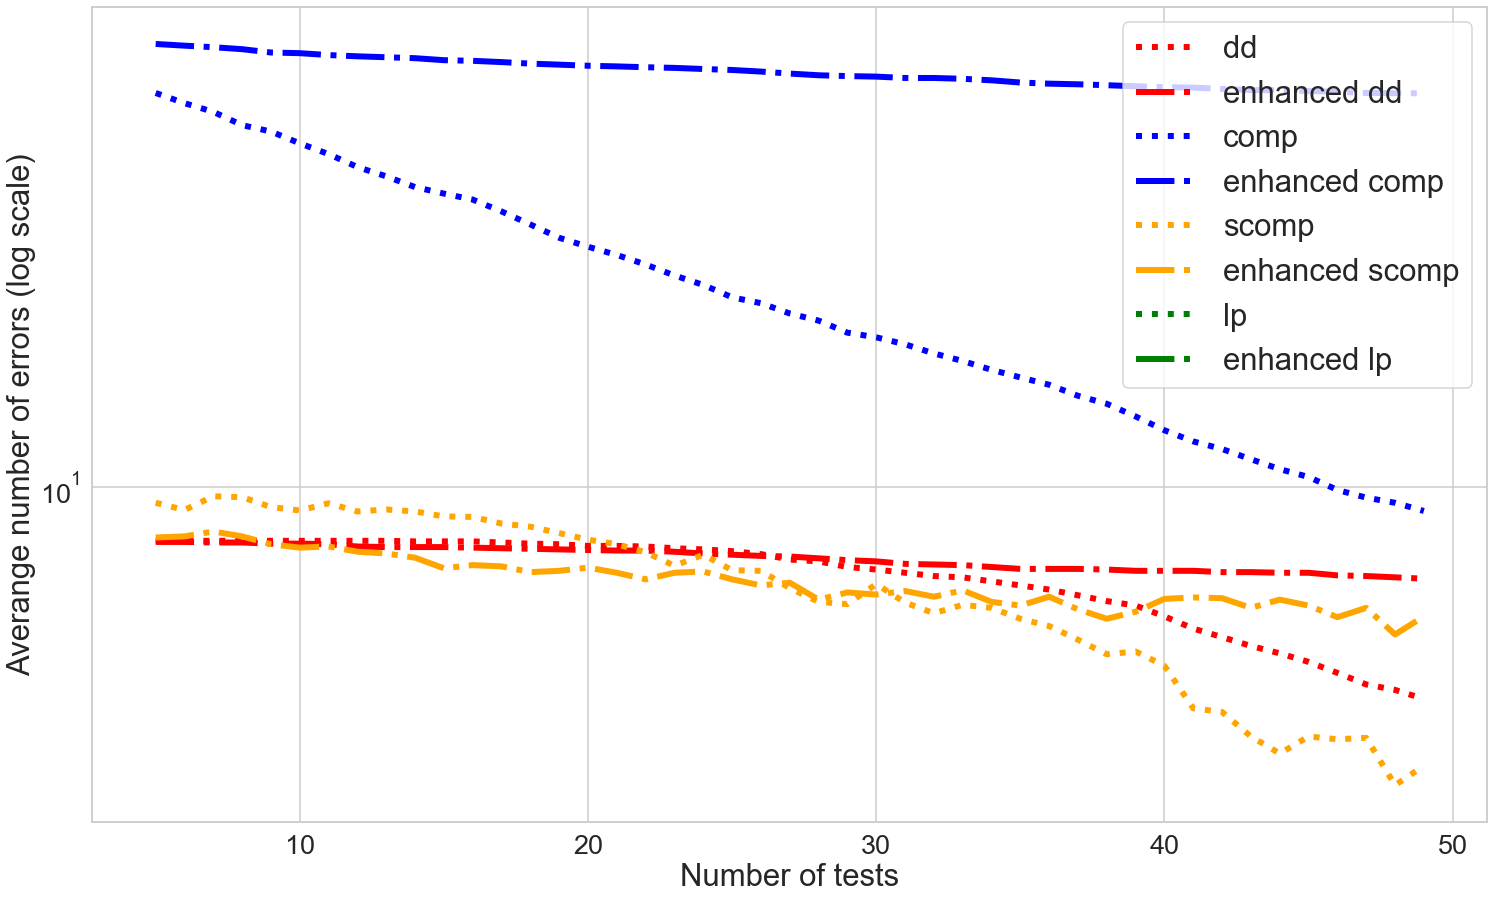

In [9]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_nerr[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_nerr[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_nerr[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_nerr[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_nerr[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_nerr[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_nerr[z:], label='lp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_nerr[z:], label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Averange number of errors (log scale)', fontsize='xx-large')
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('softexampleavr.pdf')

plt.show()

## Soft-hard thresholding 

In [59]:
importlib.reload(rec)

n_tests = 100
max_test_size = 100
samplesize= 600
threshold = 0.39
err = 5
z = 20

enhanced_dd_succes = np.zeros(max_test_size)
dd_succes = np.zeros(max_test_size)
enhanced_dd_errors = np.zeros(max_test_size)
dd_errors = np.zeros(max_test_size)


comp_succes = np.zeros(max_test_size)
enhanced_comp_succes = np.zeros(max_test_size)
comp_errors = np.zeros(max_test_size)
enhanced_comp_errors = np.zeros(max_test_size)


scomp_succes = np.zeros(max_test_size)
enhanced_scomp_succes = np.zeros(max_test_size)
scomp_errors = np.zeros(max_test_size)
enhanced_scomp_errors = np.zeros(max_test_size)

lp_succes = np.zeros(max_test_size)
enhanced_lp_succes = np.zeros(max_test_size)
lp_errors = np.zeros(max_test_size)
enhanced_lp_errors = np.zeros(max_test_size)

enhanced_dd_nerr = np.zeros(max_test_size)
dd_nerr = np.zeros(max_test_size)

comp_nerr = np.zeros(max_test_size)
enhanced_comp_nerr = np.zeros(max_test_size)

scomp_nerr = np.zeros(max_test_size)
enhanced_scomp_nerr = np.zeros(max_test_size)

lp_nerr = np.zeros(max_test_size)
enhanced_lp_nerr = np.zeros(max_test_size)

for test in tqdm.tqdm(np.arange(n_tests)): 
    
    data = generate_blobs(samplesize,sparsity_regime="vsparse",sparsity_parameter=40)
    
    full_sample_y = data["True status"]
    
    full_rectified = data["Rectified status"]
    
    full_predicted = data["Predicted status"]
    
    randomness = np.random.uniform(0,1,len(data))
    probas = np.array(data['Predicted probability'])
    selected = [randomness < probas**(1/4)]
    selected_items = np.where(randomness<probas)[0]
    selected_data=data.loc[selected_items, :]
    selected_y = selected_data.iloc[:,0]
    
    k = np.count_nonzero(full_sample_y)
    
    p = 1/k
    
    k_enhanced = np.count_nonzero(selected_y)
    
    if k_enhanced == 0:
        
        p_enhanced = p
        
    else:
    
        p_enhanced = 1/k_enhanced
    
    enhanced_matrix = b_tests(max_test_size,len(selected_y),p_enhanced)
    
    full_matrix = b_tests(max_test_size,len(full_sample_y),p)
    
    for size in np.arange(z,max_test_size):
        
        full_rectified = data["Rectified status"]
        
        enhanced_test_matrix = enhanced_matrix[0:size+1,:]
        test_matrix = full_matrix[0:size+1,:]

        dd = rec.DD(full_sample_y,test_matrix)
        succes = (dd.reconstruct() == full_sample_y).all()
        dd_succes[size] += succes*1
        dd_errors[size] += error_count(full_sample_y,dd.reconstruct(),err)
        dd_nerr[size] += error_n(full_sample_y,dd.reconstruct())
        
        
        comp = rec.COMP(full_sample_y,test_matrix)
        succes = (comp.reconstruct() == full_sample_y).all()
        comp_succes[size] += succes*1
        comp_errors[size] += error_count(full_sample_y,comp.reconstruct(),err)
        comp_nerr[size] += error_n(full_sample_y,comp.reconstruct())

        
        scomp = rec.SCOMP(full_sample_y,test_matrix)
        succes = (scomp.reconstruct() == full_sample_y).all()
        scomp_succes[size] += succes*1
        scomp_errors[size] += error_count(full_sample_y,scomp.reconstruct(),err)
        scomp_nerr[size] += error_n(full_sample_y,scomp.reconstruct())

        
        lp = rec.LP(full_sample_y,test_matrix)
        succes = (lp.reconstruct() == full_sample_y).all()
        lp_succes[size] += succes*1
        lp_errors[size] += error_count(full_sample_y,scomp.reconstruct(),err)
        lp_nerr[size] += error_n(full_sample_y,lp.reconstruct())

        
        
        enhanced_dd = rec.DD(selected_y,enhanced_test_matrix)
        enhanced_comp = rec.COMP(selected_y,enhanced_test_matrix)
        enhanced_scomp = rec.SCOMP(selected_y,enhanced_test_matrix)
        enhanced_lp = rec.LP(selected_y,enhanced_test_matrix)
        
        dd_reconstructed_suspicious = enhanced_dd.reconstruct()
        comp_reconstructed_suspicious = enhanced_comp.reconstruct()
        scomp_reconstructed_suspicious = enhanced_scomp.reconstruct()
        lp_reconstructed_suspicious = enhanced_lp.reconstruct()
        
        
        #enhanced comp metrics
        
        full_rectified[selected_items] = comp_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_comp_succes[size] += succes*1
        enhanced_comp_errors[size] += error_count(full_rectified,full_sample_y,err)
        enhanced_comp_nerr[size] += error_n(full_rectified,full_sample_y)

            
        #enhanced dd metrics 
        
        full_rectified[selected_items] = dd_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_dd_succes[size] += succes*1
        enhanced_dd_errors[size] += error_count(full_rectified,full_sample_y,err)
        enhanced_dd_nerr[size] += error_n(full_rectified,full_sample_y)

        
        #enhanced scomp metrics 
        
        full_rectified[selected_items] = scomp_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_scomp_succes[size] += succes*1
        enhanced_scomp_errors[size] += error_count(full_rectified,full_sample_y,err)
        enhanced_scomp_nerr[size] += error_n(full_rectified,full_sample_y)

        
        #enhanced lp metrics 
        
        full_rectified[selected_items] = lp_reconstructed_suspicious
        succes = (full_rectified == full_sample_y).all()
        enhanced_lp_succes[size] += succes*1
        enhanced_lp_errors[size] += error_count(full_rectified,full_sample_y,err)
        enhanced_lp_nerr[size] += error_n(full_rectified,full_sample_y)



enhanced_dd_succes *= 1/n_tests
enhanced_comp_succes *= 1/n_tests
enhanced_scomp_succes *= 1/n_tests
enhanced_lp_succes *= 1/n_tests

enhanced_dd_errors *= 1/n_tests
enhanced_comp_errors *= 1/n_tests
enhanced_scomp_errors *= 1/n_tests
enhanced_lp_errors *= 1/n_tests

dd_succes *= 1/n_tests
comp_succes *= 1/n_tests
scomp_succes *= 1/n_tests
lp_succes *= 1/n_tests

dd_errors *= 1/n_tests
comp_errors *= 1/n_tests
scomp_errors *= 1/n_tests
lp_errors *= 1/n_tests

enhanced_dd_nerr *= 1/n_tests 
dd_nerr *= 1/n_tests


comp_nerr *= 1/n_tests
enhanced_comp_nerr *= 1/n_tests



scomp_nerr *= 1/n_tests
enhanced_scomp_nerr *= 1/n_tests


lp_nerr *= 1/n_tests
enhanced_lp_nerr *= 1/n_tests


100%|██████████| 100/100 [11:31<00:00,  6.91s/it]


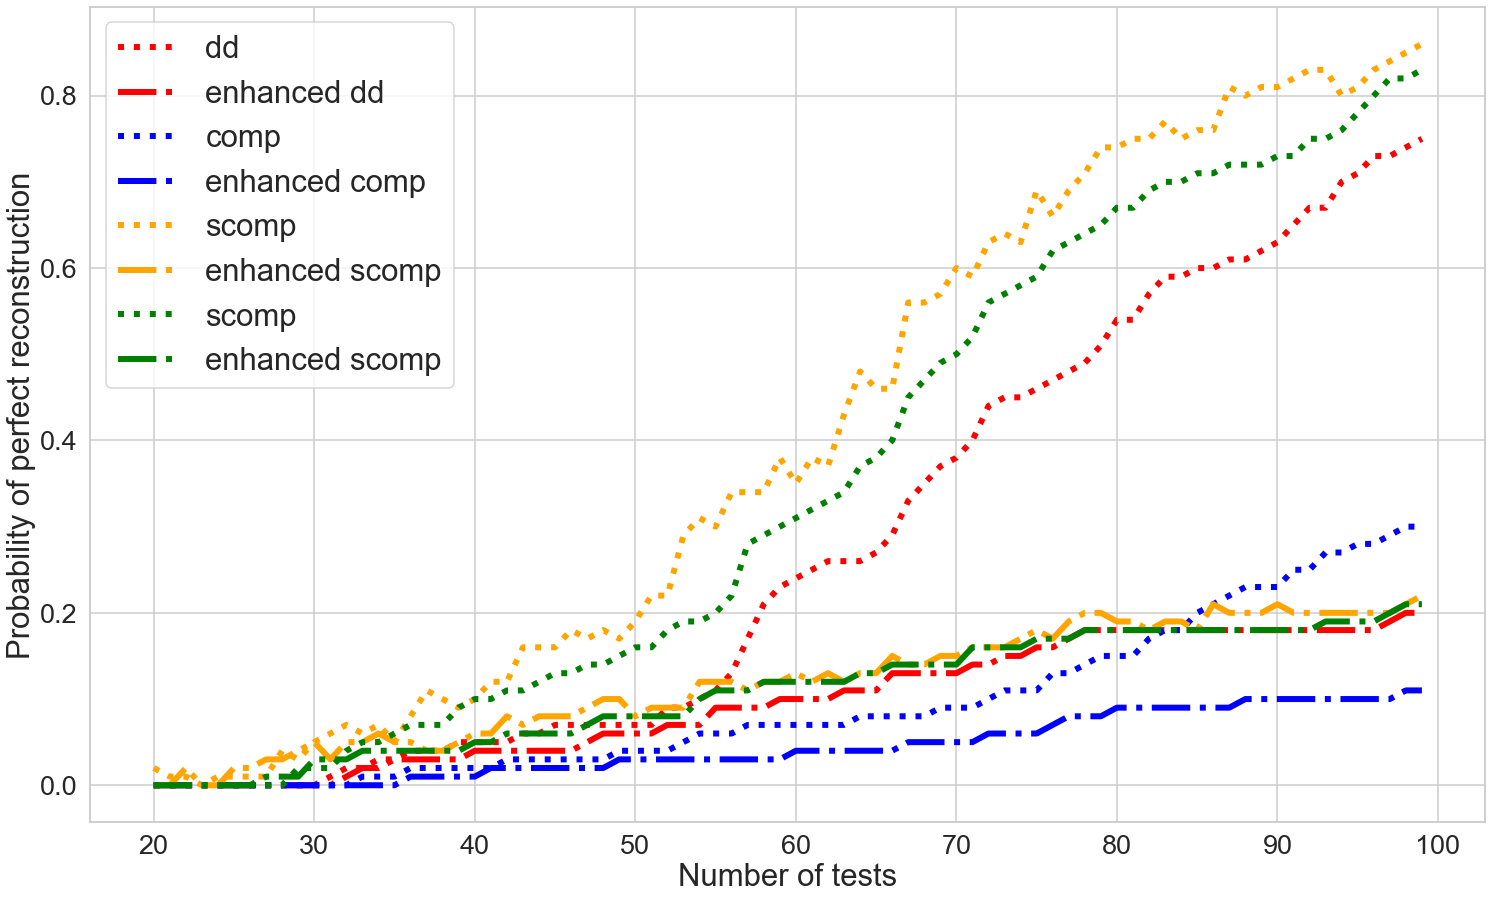

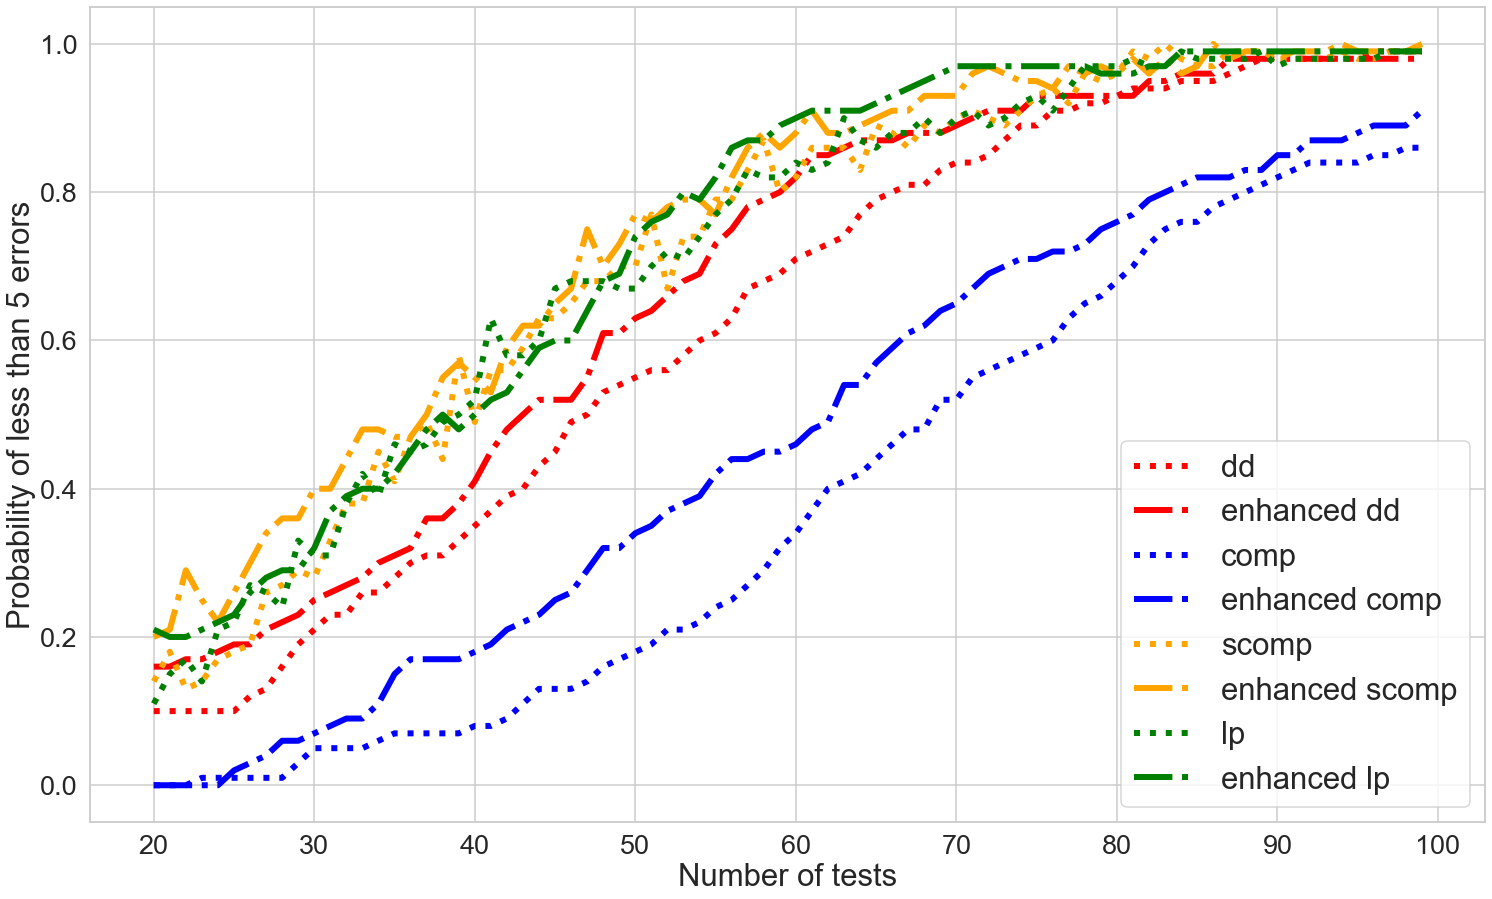

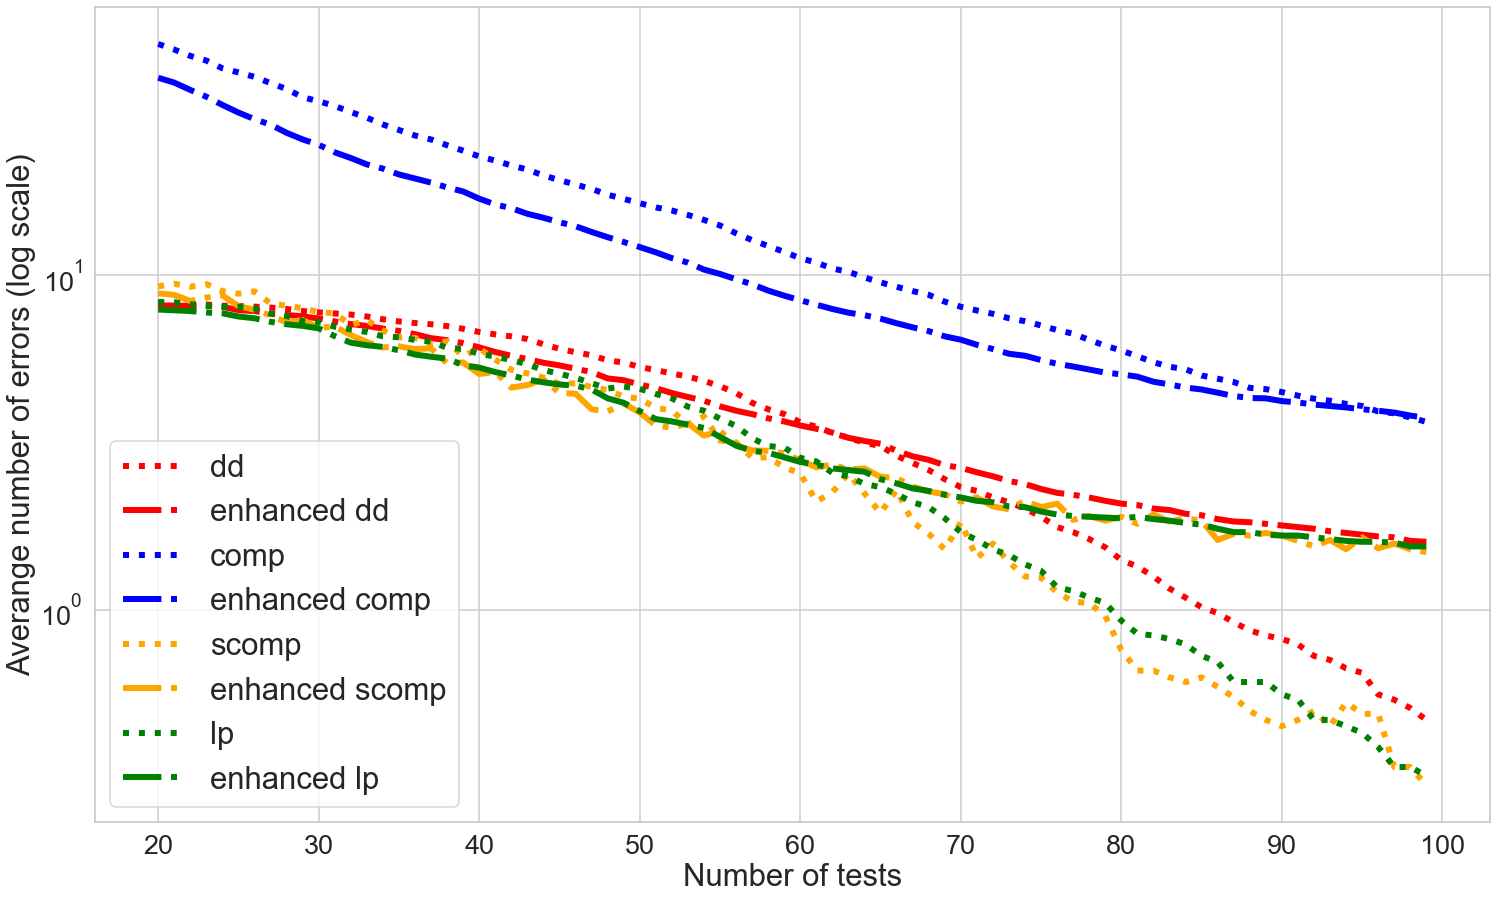

In [61]:
sns.set_context('talk')
sns.set_style('whitegrid')

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_succes[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_succes[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_succes[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_succes[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_succes[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_succes[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_succes[z:], label='scomp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_succes[z:], label ='enhanced scomp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of perfect reconstruction', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('shperf.pdf')

plt.show()

f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_errors[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_errors[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_errors[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_errors[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_errors[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_errors[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_errors[z:], label='lp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_errors[z:], label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Probability of less than 5 errors', fontsize='xx-large')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('shless5.pdf')

plt.show()


f,ax = plt.subplots(figsize=(25,15))

ax.plot(np.arange(z,max_test_size),dd_nerr[z:], label='dd',linestyle='dotted', c='red', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_dd_nerr[z:], label ='enhanced dd',linestyle='-.', c='red',linewidth=6)
ax.plot(np.arange(z,max_test_size),comp_nerr[z:], label='comp',linestyle='dotted',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_comp_nerr[z:], label ='enhanced comp',linestyle='-.',c='blue', linewidth=6)
ax.plot(np.arange(z,max_test_size),scomp_nerr[z:], label='scomp',linestyle='dotted',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_scomp_nerr[z:], label ='enhanced scomp',linestyle='-.',c='orange', linewidth=6)
ax.plot(np.arange(z,max_test_size),lp_nerr[z:], label='lp',linestyle='dotted',c='green', linewidth=6)
ax.plot(np.arange(z,max_test_size),enhanced_lp_nerr[z:], label ='enhanced lp',linestyle='-.',c='green', linewidth=6)
ax.legend(fontsize='xx-large')
ax.set_xlabel('Number of tests', fontsize='xx-large')
ax.set_ylabel('Averange number of errors (log scale)', fontsize='xx-large')
ax.set_yscale('log')
ax.tick_params(axis='both', labelsize=27)
plt.savefig('shavr.pdf')

plt.show()